# Face Identification Classifier

### Ref https://github.com/peteryuX/arcface-tf2

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from models import ArcFaceModel
# from losses import SoftmaxLoss
from losses import softmax_loss
import dataset
import tensorflow as tf
import os
import logging

import cv2
import numpy as np

from glob import glob

tf.get_logger().setLevel(logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
!echo $CUDA_VISIBLE_DEVICES

3


In [3]:
# batch_size = 128 # Initially 128
# input_size = 112
# embd_shape = 512
# head_type = 'ArcHead' # ''ArcHead', CosHead', 'SphereHead'
# # Backbones w/ pretrained weights:
# #     MobileNet, MobileNetV2, InceptionResNetV2, InceptionV3, ResNet50, ResNet50V2, ResNet101V2, NASNetLarge, NASNetMobile, Xception
# #     But if you are trying to use NasNet, please check this issue first: https://github.com/keras-team/keras-applications/issues/78
# #         We manually download the weight file and explicitly load it in models.py file
# # Backbones w/o pretrained weights:
# #     MobileNetV3Large, MobileNetV3Small, EfficientNetLite0~6, EfficientNetB0~7
# backbone_type = 'ResNet50' 
# w_decay=5e-4
# num_classes = 85742 
# dataset_len = 5822653 
# base_lr = 0.01 # initially 0.01
# epochs = 20
# save_steps = 1000
# train_size = int(0.8 * dataset_len)
# steps_per_epoch = train_size // batch_size
# val_size = dataset_len - train_size
# validation_steps = val_size // batch_size
# steps = 1
# is_ccrop=False
# binary_img=True
# is_Adam = False
# dgx = True

batch_size = 128 # Initially 128
input_size = 112
embd_shape = 512
is_ccrop=False
binary_img=True

is_Adam = False   # True
dgx = True
projection_head = False  # False

head_type = 'CurHead' # ''ArcHead', CosHead', 'SphereHead', 'CurHead', 'AdaHead', SvxHead'
# Backbones w/ pretrained weights:
#     MobileNet, MobileNetV2, InceptionResNetV2, InceptionV3, ResNet50, ResNet50V2, ResNet101V2, NASNetLarge, NASNetMobile, Xception, MobileNetV3Large, MobileNetV3Small, EfficientNetLite0~6, EfficientNetB0~7
# Backbones w/o pretrained weights:
#      MnasNetA1, MnasNetB1, MnasNetSmall 
backbone_type = 'EfficientNetB6' 
   
print("proj_head:", projection_head)    
print(head_type)
print(backbone_type)
print("Adam:", is_Adam)

proj_head: False
CurHead
EfficientNetB6
Adam: False


### Find latest checkpoint

In [4]:
if is_Adam:
    version = "Adam"
else:
    version = "SGD"
    
if dgx:
    base_dir = "/raid/workspace/honghee/FaceRecognition/checkpoints/w_tfidentity/"
    # save_name = "ms1m_mobilenet_check/SGD/*"
    if projection_head:
        save_name = f'ms1m_{backbone_type}_{head_type}_ProjectionHead_check/{version}/*'
    else:
        save_name = f'ms1m_{backbone_type}_{head_type}_check/{version}/*'
else:
    base_dir = "/hd/honghee/models/checkpoints/w_tfidentity/"
    save_name = f'ms1m_{backbone_type}_{head_type}_check/{version}/*'   

    
## collect loss in checkpoints
file_list = []
for files in glob(f'{base_dir}{save_name}'):
    if not files.split('/')[-1].split('l_')[-1].split('.ckpt')[0] == 'checkpoint':
        loss = float( files.split('/')[-1].split('l_')[-1].split('.ckpt')[0] )
    file_list.append( loss  )
file_list.sort()

load_file_name = []
for files in glob(f'{base_dir}{save_name}'):
    if files.split('/')[-1].split('l_')[-1].split('.ckpt')[0] == 'checkpoint':
        pass
    elif file_list[0] == float( files.split('/')[-1].split('l_')[-1].split('.ckpt')[0] ) and files.split('/')[-1].split('l_')[-1].split('.ckpt')[-1]!='.index':
        load_file_name = files
best_checkpoint = load_file_name.split('.data')[0]
initial_epoch = int(load_file_name.split('e_')[-1].split('_')[0])-1
print(best_checkpoint)

/raid/workspace/honghee/FaceRecognition/checkpoints/w_tfidentity/ms1m_EfficientNetB6_CurHead_check/SGD/e_13_l_0.45935317873954773.ckpt


# Training Face Identification Classifier

In [5]:
import numpy as np
import tensorflow as tf
from pathlib import Path
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from layers import ArcMarginPenaltyLogists
from losses import softmax_loss
from models import ArcFaceModel
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

weight_file = best_checkpoint

model = ArcFaceModel(size=input_size,
                         backbone_type=backbone_type,
                         training=False)
model.load_weights(weight_file)
model.summary()

Model: "arcface_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 112, 112, 3)]     0         
_________________________________________________________________
efficientnetb6 (Functional)  (None, 4, 4, 2304)        40960136  
_________________________________________________________________
OutputLayer (Functional)     (None, 512)               18886144  
Total params: 59,846,280
Trainable params: 59,610,584
Non-trainable params: 235,696
_________________________________________________________________


### Extract Embedding Vectors & Create Classifier Training Dataset

In [6]:
import cv2
import numpy as np
from utils import l2_norm
from glob import glob
from tqdm import tqdm

# dataset_path = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
dataset_path = "/raid/workspace/jbpark/IJB-C_Asian/Aligned/"


In [7]:
import os 
from tqdm import tqdm
id_list = os.listdir(dataset_path)
id_list.sort()
source_id = []
for id_name in tqdm(id_list):
    source_id.append(int(id_list.index(id_name)))
len(np.unique(np.array(source_id)))

FileNotFoundError: [Errno 2] No such file or directory: '/raid/workspace/jbpark/IJB-C_Asian/Aligned/'

In [ ]:
subjects = id_list
label_int = source_id
embed_list = []
label_list = []
for subject in tqdm(subjects):
#     print("[*] Encode {} to Embedding Vector ({})".format(subject,embd_shape))
    img_paths = glob(dataset_path+subject+"/*")
    for img_path in img_paths:
#         print("[*] Encode {} to ./output_embeds.npy".format(img))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (112,112))
        img = img.astype(np.float32) / 255.
        # print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
        if len(img.shape) == 3:
            img = np.expand_dims(img, 0)

    #     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
        embeds = l2_norm(model(img, training=False))
        print("embedding: ", embeds)
    #     embeds.shape
    #     embeds
        embed_list.append(embeds[0].numpy())
        label_list.append(label_int[subjects.index(subject)])
embed_list = np.asarray(embed_list)
label_list = np.asarray(label_list)
# embed_list

  0%|          | 0/3585 [00:00<?, ?it/s]

embedding:  tf.Tensor(
[[ 0.02629297 -0.04933494  0.01161736 -0.00568421 -0.00390898 -0.09537674
   0.04495392 -0.04182286 -0.02036719  0.0670693  -0.06042095 -0.01768342
  -0.04487198  0.03460452 -0.01817408  0.02142602 -0.02742175 -0.00060344
   0.06406503  0.07271695  0.04719786  0.00584928 -0.04586715  0.01680507
   0.04609346  0.01676042  0.00725228 -0.0267726  -0.03551272 -0.04880058
  -0.03792391  0.01505536  0.00627127 -0.00875104  0.03251698 -0.00980187
  -0.05642711 -0.02971342  0.04980849  0.01829013 -0.03149751  0.02937992
  -0.09843005  0.01808497 -0.00900947 -0.03204119  0.00280543  0.00587311
   0.01773235 -0.00885637  0.01231549 -0.07707561 -0.0103955  -0.01276266
   0.04958154  0.01774964  0.07323688  0.02457351 -0.00340162 -0.00784511
  -0.04250392  0.03833947 -0.0349036   0.05723213 -0.00676932  0.0399889
  -0.05241822 -0.02237072  0.00946904  0.00782691 -0.03292547 -0.03561752
  -0.04635826  0.03074761  0.0071911   0.00472818 -0.03741837 -0.02246735
  -0.10960493  0

embedding:  tf.Tensor(
[[ 6.45077750e-02 -5.25014177e-02 -2.95556728e-02 -8.18221346e-02
  -1.86245088e-02  6.45398675e-03  3.74315353e-03 -1.49663948e-02
   2.51950752e-02 -9.20175947e-03 -1.74126513e-02 -3.21681425e-02
   6.23543514e-03  3.69204953e-02  4.79744077e-02 -2.79860161e-02
  -6.57174066e-02 -1.97561663e-02  3.99901196e-02  5.70839969e-03
  -4.41188850e-02 -7.89012611e-02 -2.72080544e-02 -2.79988982e-02
  -1.22342268e-02 -3.72430868e-02 -6.57765428e-03 -6.73563406e-02
   5.60291670e-03  6.26051472e-03  1.06461933e-02  4.43753153e-02
   2.61729583e-02  5.44664450e-03  2.94378567e-02  7.98775814e-03
  -6.47257417e-02 -5.52090481e-02 -1.93911288e-02  7.05648810e-02
  -3.24599519e-02 -2.54163686e-02 -9.56806317e-02 -8.68705064e-02
   5.19884750e-02 -7.40390196e-02 -2.79929885e-03 -8.54824111e-03
  -1.41274519e-02 -7.86263272e-02  5.42584583e-02 -2.44647041e-02
  -1.16931982e-01  6.97732493e-02 -5.99733088e-03 -5.05014248e-02
  -1.36218092e-03  5.86967021e-02 -1.69517249e-02  1.

  0%|          | 1/3585 [00:07<7:56:11,  7.97s/it]

embedding:  tf.Tensor(
[[-5.99398650e-03  1.50108868e-02 -1.04121283e-01 -4.42971624e-02
  -1.42289279e-02 -7.18543120e-03  2.68178955e-02  3.15449294e-03
  -2.45437790e-02  5.68725467e-02 -7.08559528e-02  9.02864151e-03
  -4.08085063e-02 -2.40520407e-02 -5.05973138e-02 -1.82458032e-02
  -8.53114389e-03 -7.41895065e-02  1.07480071e-01  5.61866090e-02
  -4.13370738e-03 -2.76164170e-02 -4.27570269e-02 -4.27277908e-02
   2.88228206e-02  2.42322385e-02  1.92980915e-02 -2.02193409e-02
  -2.94418521e-02 -2.37984546e-02 -1.20216911e-03  7.50143304e-02
  -1.74482130e-02  4.16170359e-02  9.23798755e-02 -3.52680497e-02
   2.12061908e-02 -1.02246627e-02  3.97546999e-02  7.19308704e-02
  -1.01855099e-02 -1.84449870e-02 -6.55123815e-02  4.05503064e-02
   5.81678515e-03  8.21053330e-03 -3.53357531e-02 -7.47205392e-02
   3.39250565e-02 -6.93645254e-02  3.61916199e-02  5.09331329e-03
  -7.25682330e-05 -4.61388044e-02  4.66882326e-02  3.51819657e-02
   6.38368055e-02  4.31367680e-02 -2.16374779e-03 -1.

  0%|          | 2/3585 [00:08<3:23:35,  3.41s/it]

embedding:  tf.Tensor(
[[-4.20962973e-03  4.37573865e-02 -3.00810188e-02 -2.37879716e-02
  -2.78964676e-02 -1.49443865e-01 -2.92429235e-02  1.99579969e-02
   2.52174661e-02  6.60143942e-02 -3.67019214e-02  1.39996363e-02
   4.97342534e-02 -1.38942311e-02 -5.59102781e-02  6.56642392e-02
   1.79144908e-02  2.02302337e-02  9.86385345e-03 -4.82152253e-02
   3.59081253e-02 -9.02094170e-02 -2.92994604e-02 -4.39148992e-02
  -9.92304552e-03 -1.49220647e-02 -2.49607582e-02 -1.82920657e-02
  -1.97297614e-03 -4.82064597e-02  7.22960681e-02 -6.52065547e-03
   5.05353175e-02  6.74647838e-02 -2.20727194e-02  4.69279988e-03
  -4.61548269e-02  3.35720554e-02  1.27316546e-02  1.25225678e-01
   2.14308035e-02 -1.66739728e-02 -4.45635952e-02  7.21703544e-02
   2.23651454e-02 -4.85866442e-02  5.27888611e-02 -3.47562619e-02
   1.66049674e-02 -5.60407266e-02  1.16767026e-01 -2.66778450e-02
  -6.86104130e-03 -2.46915268e-03  9.03424621e-03 -2.07718145e-02
   3.64596620e-02  5.50672114e-02  2.33670347e-03  4.

embedding:  tf.Tensor(
[[-5.43765612e-02 -5.06280288e-02  4.82382923e-02 -6.82417601e-02
  -1.38641195e-03  3.59306810e-03 -7.72071406e-02  2.03336440e-02
   3.17785777e-02  4.82818624e-03  6.85403198e-02  7.21169412e-02
  -5.91287389e-03  2.12547369e-02  3.57217565e-02 -5.68090193e-02
   1.54216513e-02 -4.32981551e-03  6.34852499e-02  2.47734617e-02
   3.09040323e-02  5.21044917e-02  8.55032913e-03  2.47816313e-02
   3.46759260e-02 -9.58734658e-03 -1.01575942e-03  5.99943427e-03
   5.02024367e-02  1.75062101e-02 -2.45071854e-02 -5.04845046e-02
  -2.94446349e-02  1.40481815e-02  1.76963918e-02 -2.33052224e-02
   2.84339208e-02 -9.21470951e-03  3.10368314e-02  8.21352378e-02
   2.36059912e-02 -6.50939494e-02 -2.28507374e-03  1.62524451e-02
   4.21148725e-02  8.09350982e-02 -7.02711195e-03  4.06950898e-02
   4.40030061e-02 -1.78329181e-02 -1.99506730e-02  1.26282871e-01
  -4.91936365e-03 -1.48415998e-01  5.73693551e-02  5.09628728e-02
  -3.46498117e-02 -6.13442771e-02 -9.42150727e-02  1.

embedding:  tf.Tensor(
[[ 5.67382609e-04 -2.50313943e-03  1.74305178e-02 -9.62206572e-02
   5.37597016e-02 -1.13468170e-01 -8.42122287e-02  3.70653579e-03
   3.25512551e-02 -1.91089660e-02  5.60162403e-02  2.38287691e-02
  -4.33123447e-02  5.61821237e-02  1.52589818e-02 -6.35766387e-02
   1.60159487e-02  4.23427252e-03 -3.93645242e-02  2.12358572e-02
   5.90882711e-02  3.47295590e-02 -1.91788096e-02 -6.68495223e-02
   5.28042056e-02 -1.70979351e-02  1.13631366e-02  6.68289959e-02
   1.01456335e-02  7.96947721e-03  1.64597575e-02 -3.72668891e-03
  -2.42765751e-02  4.54826327e-03  1.24781514e-02 -8.74614529e-03
  -2.67139953e-02 -9.24011227e-03  6.32485375e-03  3.97489183e-02
  -9.60260257e-03 -2.96470448e-02  5.25138974e-02  2.36005243e-02
  -1.32223498e-02  1.19632527e-01 -4.40490954e-02  5.04285209e-02
   4.42719199e-02 -4.90108430e-02 -1.16799269e-02  5.33922622e-03
  -1.33526642e-02 -2.74746865e-03  8.48751888e-02  5.37132751e-03
  -3.62069048e-02  3.49664353e-02 -7.12129846e-02  1.

  0%|          | 3/3585 [00:09<2:14:02,  2.25s/it]

embedding:  tf.Tensor(
[[-6.38553202e-02 -8.85205194e-02  2.42135447e-05 -7.13839829e-02
   3.48639153e-02 -3.10580377e-02 -7.83627406e-02  8.13287869e-03
   7.16202557e-02 -6.02996759e-02  5.94061501e-02  4.57279235e-02
  -2.40338687e-02  4.44744527e-03  3.08233723e-02 -4.87116445e-03
   2.48893965e-02  2.31784340e-02 -1.52618380e-03 -5.23927920e-02
   5.91592230e-02  1.32174499e-03  8.28491598e-02  3.51098925e-02
   8.31406116e-02  7.83122890e-03 -2.84143183e-02 -3.01511697e-02
   3.35595608e-02 -2.34243050e-02 -3.51818688e-02 -8.32002982e-02
  -4.47367728e-02 -5.33311581e-03  3.13376896e-02 -4.99043204e-02
   4.11579981e-02 -3.85249630e-02  2.61370782e-02  4.06652018e-02
  -5.16112568e-03 -3.25575471e-02 -1.14853214e-02 -4.51425500e-02
  -4.26514540e-03  6.78221434e-02 -5.10329045e-02  9.84514132e-02
   9.44058876e-03 -3.25256609e-03  4.38899063e-02  8.10084045e-02
  -3.34565826e-02 -8.80097225e-02  5.24487495e-02  1.33810872e-02
  -1.99204162e-02 -1.38549320e-02 -6.34845942e-02  8.

  0%|          | 4/3585 [00:09<1:26:41,  1.45s/it]

embedding:  tf.Tensor(
[[-3.82676162e-02  9.61725414e-02 -7.60096870e-03 -3.34804947e-03
   1.69280134e-02  7.34583735e-02  1.25737945e-02  7.03766942e-02
  -1.27665661e-02 -6.33939579e-02 -7.68101886e-02 -5.55608980e-02
   2.03901902e-02  2.40443610e-02  5.23620471e-03 -3.88416760e-02
   7.47530081e-04 -4.25145077e-03  4.50769477e-02 -4.57848310e-02
   5.40015623e-02 -1.65660605e-02 -6.01973608e-02 -2.32691299e-02
   6.55052215e-02  3.23936567e-02  1.51160434e-02 -1.21029271e-02
  -1.04785366e-02 -2.34823432e-02  1.36225345e-02 -1.19119719e-01
  -1.00892810e-02  5.50295152e-02 -1.30427105e-03  4.34687845e-02
  -1.61524285e-02 -2.30404232e-02  2.12257095e-02 -5.26312180e-02
  -3.64949554e-02  8.48374367e-02 -4.05143499e-02 -6.46857824e-03
   4.60187420e-02  1.47375080e-03  5.29017933e-02  4.44097584e-03
   1.58635899e-03  1.57667752e-02  4.29623239e-02 -7.04826638e-02
   4.07591742e-03  6.37617186e-02  1.21559193e-02  1.40606472e-02
  -1.44353658e-02  5.14270924e-02  1.97941512e-02  1.

embedding:  tf.Tensor(
[[ 4.45924066e-02 -6.15635104e-02 -5.09719029e-02  6.32965658e-03
   9.70749650e-03  1.98712051e-02 -7.03059062e-02  7.63075566e-03
   1.27723748e-02  1.68226473e-02 -1.60371803e-03 -1.23038702e-02
   2.72127893e-03  6.56192601e-02 -9.87912808e-03  3.02057751e-02
   7.45377019e-02  3.32907098e-03 -2.78107822e-02  6.99018538e-02
   6.02234304e-02 -2.49078497e-02 -4.00590599e-02 -6.16603270e-02
   3.26174423e-02 -2.36729644e-02  2.16069017e-02  4.44504544e-02
   3.90945282e-03  6.93440512e-02 -5.18402644e-02 -1.38627533e-02
  -2.66676433e-02 -3.99277452e-03  2.96412059e-03  3.79821770e-02
   4.53543998e-02 -7.62924626e-02  6.06961884e-02 -1.04860691e-02
   1.88811738e-02  1.07714310e-02 -4.91047762e-02 -2.14860681e-02
  -1.78847872e-02 -1.37202144e-02  5.99727556e-02 -4.02954184e-02
   2.23299731e-02 -4.06716727e-02 -3.17953303e-02  5.63796610e-02
  -3.10204346e-02  2.63636783e-02 -1.50938490e-02  1.92165273e-04
   1.14774713e-02  2.49443743e-02  5.07872850e-02  2.

embedding:  tf.Tensor(
[[ 3.05440668e-02 -5.39599359e-02 -3.94224040e-02 -2.62527494e-03
  -9.63335112e-03 -2.57489141e-02  1.61980502e-02 -5.60341328e-02
   1.38749415e-02  2.57661697e-02 -6.92914352e-02  1.82444062e-02
  -1.61127970e-02  4.36559245e-02  5.04212901e-02 -5.44367954e-02
   6.72885999e-02  1.33285066e-02 -4.29125465e-02 -5.88780679e-02
   1.24795092e-02  2.35174000e-02 -1.73016135e-02 -3.11438786e-03
   3.98105290e-03 -2.61636283e-02 -4.12907116e-02 -4.02789190e-02
  -5.48361689e-02  2.12857798e-02 -8.93739387e-02 -5.79166785e-02
  -1.19633880e-02  8.04608390e-02  2.57734172e-02  4.39499766e-02
   7.90570602e-02 -3.20676994e-03 -1.12338327e-02 -1.03592407e-02
   1.36165274e-02  3.36126424e-02 -6.67471811e-02 -2.44147088e-02
   2.08250321e-02 -1.02268644e-01 -3.97355556e-02  6.24506176e-02
   1.61154792e-02 -4.88495547e-03  3.00727803e-02  6.82034418e-02
  -1.03253461e-02 -4.35516015e-02  3.96310836e-02 -8.23948346e-03
  -2.56299991e-02  5.79682179e-02  1.90457348e-02 -1.

embedding:  tf.Tensor(
[[ 2.52063647e-02  1.17535824e-02 -3.73613485e-03 -1.38410907e-02
  -1.22510791e-02  1.25779836e-02 -2.94245500e-02 -6.77441771e-04
   6.75534457e-02  2.30914075e-02 -8.94265398e-02  3.58196832e-02
   1.42154451e-02  6.58905506e-02  4.16419562e-03  1.29297925e-02
   7.77702853e-02 -8.95324536e-03 -5.91089390e-02  1.05038658e-02
   4.75520007e-02 -2.98073366e-02 -2.07502600e-02 -3.51042859e-02
  -6.64612204e-02  2.75879055e-02 -6.66733161e-02  6.45715790e-03
   1.83235714e-03 -1.67737082e-02 -4.61416803e-02 -2.24807803e-02
   4.99496097e-03  1.91173721e-02  9.64893587e-03  2.83514010e-03
   5.31267114e-02 -3.94597650e-02 -4.08926494e-02  2.60528289e-02
   2.59829797e-02  4.64913771e-02 -8.92344639e-02 -3.53223458e-02
   2.60240976e-02  1.10600153e-02 -5.63750975e-03  1.22334119e-02
   1.18795503e-02 -4.91832495e-02 -1.68225188e-02  5.45908809e-02
  -4.81286123e-02 -4.66357842e-02  4.31486499e-03 -1.14878574e-02
   3.41588520e-02  5.54583259e-02  5.43460101e-02 -5.

embedding:  tf.Tensor(
[[ 2.11327914e-02 -3.31649743e-02  7.44916033e-03  1.92986522e-02
  -4.06055059e-03  3.43586318e-02 -5.72218560e-02 -6.47600740e-02
   3.47652622e-02  2.24622916e-02  1.59654729e-02  6.53748065e-02
  -6.79384029e-05  5.25482595e-02 -2.84763146e-02 -2.38894299e-02
   3.41575779e-02 -1.14542795e-02 -5.09194843e-02 -3.84159386e-02
   3.52721512e-02  4.85543944e-02 -6.02880642e-02 -5.05046025e-02
  -9.92543623e-03  5.24489097e-02 -6.72137812e-02  5.39031476e-02
   3.41835879e-02  8.74637440e-02 -2.04913784e-02 -4.76370007e-02
   4.19094227e-03  1.23762963e-02  2.20746957e-02  4.09651920e-02
   5.72626963e-02 -7.25566819e-02  3.59730683e-02 -4.38432060e-02
  -2.92333942e-02 -8.04197509e-03 -4.29860242e-02 -3.59692089e-02
   1.59494728e-02  1.19548105e-02 -4.86009568e-02  5.82101615e-03
  -2.85211187e-02  1.84241142e-02 -3.67185287e-02  9.56011787e-02
   2.44296305e-02 -7.16606230e-02  4.09424789e-02 -2.91177649e-02
  -9.71025601e-03 -1.21681402e-02  2.25492101e-02 -2.

embedding:  tf.Tensor(
[[ 0.03117737 -0.02936224  0.01157974  0.05369842 -0.02125593  0.03466551
  -0.06919856 -0.01070942  0.02897069  0.02080941  0.00887839  0.02692898
   0.06035842  0.05464359 -0.03029169  0.00222723  0.08755128 -0.03895762
  -0.03053659 -0.01198894  0.07649623  0.01672227 -0.06649996 -0.06372773
  -0.00107053  0.03697838 -0.07666131  0.05613113 -0.00803707  0.05972878
  -0.0316481  -0.07063515 -0.00248144  0.02111084  0.02339351  0.01557956
   0.00849276 -0.06298836  0.07150108  0.00905618 -0.04433655 -0.00327763
  -0.05112208 -0.0380176   0.02065259  0.03666585 -0.00619461 -0.02798698
   0.00592674 -0.00306193 -0.05926049  0.079449   -0.00426442 -0.05102145
   0.02606265  0.00644267  0.00399711 -0.00811847  0.03057696 -0.01540295
  -0.00693536 -0.07677042  0.05933025  0.02796161  0.03327423 -0.09341083
  -0.04033749 -0.03119588 -0.06852797  0.00326543  0.05300647 -0.04767816
  -0.05181132 -0.03781908 -0.05172375 -0.03198604  0.0240982  -0.01865345
  -0.0279075   

  0%|          | 5/3585 [00:10<1:21:14,  1.36s/it]

embedding:  tf.Tensor(
[[-1.56955281e-03 -7.52876773e-02 -2.83060735e-03 -1.29550053e-02
  -9.34052840e-03 -3.33102196e-02 -1.72570888e-02 -4.91852239e-02
   6.74507394e-02 -7.43284030e-03 -2.08976362e-02  7.12941363e-02
  -4.21929322e-02  4.71248329e-02  2.51237843e-02 -1.19133806e-02
   5.00305854e-02 -2.22798642e-02 -5.13386875e-02 -4.42382991e-02
   3.79707180e-02  2.88009644e-02  2.44345553e-02 -4.11880054e-02
  -3.50128976e-04  5.68777043e-03 -4.96816561e-02 -1.38738193e-02
  -2.59828512e-02  2.03147437e-02 -6.21013641e-02 -3.90899144e-02
   5.56305330e-03  1.17390254e-03 -3.96210887e-03  5.53990379e-02
   7.75411353e-02 -1.49316611e-02 -3.17632407e-02  3.67271639e-02
   4.00068238e-02 -1.21680079e-02 -1.89861134e-02 -1.20664807e-03
  -2.47150846e-03 -6.82551116e-02 -1.44755151e-02  5.21560945e-02
  -6.57334831e-03 -3.80648556e-03  2.10146792e-02  7.69598633e-02
  -1.30114313e-02 -6.63201734e-02  4.22625542e-02 -4.15655179e-03
  -1.45032788e-02  4.17707115e-02  1.34440884e-02 -4.

embedding:  tf.Tensor(
[[ 3.71680930e-02  1.17522394e-02  5.04283533e-02  2.35969257e-02
   3.63211408e-02  3.00195720e-03  8.31690952e-02  6.20458610e-02
   5.27613088e-02 -5.91561981e-02 -4.56282422e-02  5.27631193e-02
  -6.64997660e-03  1.63802207e-02 -6.81128260e-03 -6.61078319e-02
   5.52561134e-02 -4.26148400e-02  5.34141213e-02 -5.66293560e-02
  -2.95351315e-02 -5.51326461e-02 -8.16375315e-02 -1.00222668e-02
  -2.41212323e-02 -7.01327994e-03 -3.77282985e-02 -1.60132046e-03
   4.06891480e-02 -2.70488281e-02 -4.54545133e-02  1.76951867e-02
  -1.38299661e-02 -2.33398937e-02  3.82382050e-02  1.71974618e-02
   3.05191334e-02 -1.17699169e-02  2.29883231e-02 -1.27090430e-02
   1.47386193e-02 -1.85151175e-02  1.52442446e-02  9.75001529e-02
  -4.08573784e-02  5.33229634e-02  6.17119707e-02  1.41898114e-02
  -4.46413569e-02 -9.44163837e-03 -5.97944073e-02  6.99215233e-02
  -7.75720403e-02 -7.90409092e-03  6.02290072e-02 -2.67079063e-02
   4.76224348e-02 -2.80600451e-02  8.44816677e-03  1.

embedding:  tf.Tensor(
[[ 3.82997058e-02 -4.97194901e-02 -1.09591698e-02 -9.79079306e-03
   3.24948840e-02  3.01878937e-02 -2.53851041e-02  2.90624443e-02
   5.11031672e-02  1.78151056e-02 -1.29321292e-02 -2.79994626e-02
  -5.33028916e-02  1.09569684e-01 -2.56705452e-02 -2.35754903e-02
   4.59789112e-02  1.47136161e-02 -2.20409986e-02 -2.39637389e-04
  -2.11855210e-02 -4.38969657e-02 -6.99207857e-02 -2.83252392e-02
   6.09455109e-02 -4.21174057e-02  3.60609703e-02  4.11495641e-02
   9.47634950e-02  5.03526293e-02 -7.76892677e-02 -3.86008807e-02
  -1.29369855e-01  2.76985448e-02  1.79391578e-02  2.45194975e-02
   8.60264432e-03  3.48152556e-02 -1.17803328e-02 -1.17547624e-02
   1.73541307e-02  4.02911827e-02 -5.51392697e-02  4.56530787e-03
  -3.23653705e-02 -4.63933684e-02  5.02425469e-02  1.05297245e-01
  -2.55059991e-02 -3.93924862e-02  2.53779478e-02  4.14158180e-02
  -2.30977722e-02  1.01064898e-01  9.04758926e-04 -3.15759555e-02
   6.84006959e-02 -4.64582182e-02  3.09111066e-02  5.

embedding:  tf.Tensor(
[[ 2.72022709e-02  6.69827359e-03 -4.60464433e-02 -4.71013458e-03
   6.85896501e-02 -7.26423401e-04  3.51484977e-02 -6.12047128e-03
   6.16374426e-02 -2.29139868e-02  4.06162767e-03 -4.87783998e-02
  -4.65932488e-02  8.48663151e-02  2.06245743e-02 -4.79972959e-02
   4.87654135e-02 -4.08479152e-03 -5.94197325e-02 -7.18786493e-02
  -4.71037719e-03 -4.63765226e-02 -8.10075700e-02 -7.06988275e-02
   3.39932516e-02  4.73266467e-03  6.52592222e-04  7.89721906e-02
   3.56570631e-02  5.83880059e-02 -3.23795192e-02 -3.37016471e-02
  -9.83552933e-02  3.64532694e-02 -1.15366569e-02  2.83574779e-02
   2.66559911e-03 -1.73173066e-05  2.09446084e-02 -2.48330692e-03
   5.31514315e-03  2.45615914e-02 -4.95877489e-02 -2.77384277e-02
  -1.75880305e-02  6.84967311e-03 -1.18804714e-02  3.74624990e-02
  -3.24958526e-02 -9.30285379e-02  1.92514621e-02  6.06074519e-02
  -2.70627458e-02  3.83785926e-02 -4.74654399e-02 -6.88657090e-02
   1.41985458e-03 -3.04649286e-02 -2.10633092e-02  2.

embedding:  tf.Tensor(
[[ 0.04876792 -0.04032836 -0.01841151  0.00293618  0.05020853  0.02853783
  -0.04258618 -0.01326449  0.05187034 -0.00866738 -0.00874128  0.01695041
  -0.04555536  0.06853861 -0.05165941 -0.05499998  0.06554981 -0.02528842
   0.01011752 -0.05001184  0.01877814  0.02176127 -0.0976434  -0.04123863
   0.02585161  0.04396381 -0.01435145  0.05053782  0.04014675  0.07564478
  -0.04754361 -0.03398731 -0.12123799 -0.00894992  0.00986384 -0.01153571
   0.01156104 -0.03561017  0.00772206 -0.05220766 -0.02469122 -0.00428153
  -0.00659135  0.01515656 -0.0352349   0.09733719  0.02052462  0.04231191
  -0.00734603 -0.06802047 -0.04055604  0.07794958 -0.01809968  0.00934053
  -0.06392881 -0.00947598  0.04423466 -0.06092636 -0.00325758 -0.02052127
   0.06445865 -0.0255183  -0.01759873  0.03404574  0.01516381 -0.08521198
   0.01925761 -0.02716058 -0.03220018  0.05745029  0.07297022  0.02191554
  -0.01955084  0.06578997 -0.07289366 -0.00148142  0.04444594 -0.00388918
  -0.02727797  

  0%|          | 6/3585 [00:11<1:16:48,  1.29s/it]

embedding:  tf.Tensor(
[[ 4.19106521e-03  2.52034813e-02 -1.22298347e-03  3.55289988e-02
   4.09493893e-02  5.00129256e-03 -4.36242810e-03  1.84027869e-02
   3.99915799e-02 -1.59516390e-02  5.70475077e-03 -4.22776379e-02
   3.19443003e-04  3.08742579e-02  1.72397308e-02 -3.31149474e-02
   8.96907300e-02 -4.14204672e-02 -3.76799367e-02 -4.49763201e-02
   9.92053933e-03 -1.93977654e-02 -1.11778483e-01 -5.03253266e-02
  -1.89517178e-02  1.31007424e-02 -2.24001389e-02  1.30750567e-01
   3.57349366e-02  6.22869059e-02 -3.32684629e-02 -5.27940728e-02
  -3.69247682e-02  5.06536365e-02 -6.52125329e-02  2.63811219e-02
   3.78508084e-02 -1.55541142e-02  3.22913937e-02  4.85131145e-03
  -2.00708136e-02  1.70022659e-02 -9.06465668e-03  1.51565131e-02
   2.04061717e-03  4.24764119e-02  6.64393697e-03  4.35662940e-02
  -2.17791330e-02 -1.00754097e-01 -3.53098214e-02  2.54429672e-02
  -2.57604122e-02 -3.58898705e-03  4.94667387e-04 -7.76188746e-02
  -1.23117082e-02 -5.84995784e-02 -9.05077606e-02  4.

embedding:  tf.Tensor(
[[-3.64867784e-03 -6.20419532e-02  9.94187035e-03 -2.57988013e-02
   3.49300876e-02 -4.43771183e-02 -2.15127897e-02 -3.42949443e-02
   5.83291501e-02  1.24096097e-02 -7.06500858e-02 -4.92996946e-02
  -4.38668467e-02 -6.26406670e-02  6.55682608e-02 -3.16186785e-03
   7.86020756e-02  4.34222594e-02 -5.09901121e-02 -4.51533869e-02
   6.65709153e-02 -6.66839555e-02 -5.83283119e-02  2.44582575e-02
   1.02856473e-04 -3.32969092e-02 -8.06191266e-02 -4.90353070e-02
   1.77888125e-02 -1.11519270e-01 -3.40862125e-02 -2.61684489e-02
  -1.02448147e-02  2.82154791e-02  3.41778733e-02 -7.55342022e-02
   2.20878571e-02  6.79098070e-02  2.90636788e-04  8.16436782e-02
   2.26115994e-02  8.18395801e-03 -4.98004146e-02 -6.83441833e-02
  -3.03631441e-05 -1.42964739e-02  3.53466980e-02 -3.47334519e-02
   8.23574737e-02 -4.83138673e-02 -5.07665537e-02 -4.35663983e-02
  -2.04066765e-02 -7.45895877e-03 -4.24529538e-02 -5.42659648e-02
   1.24011375e-02  2.12510396e-02  4.53979410e-02 -2.

embedding:  tf.Tensor(
[[-6.78424314e-02 -5.36934026e-02  1.88627485e-02 -2.39107944e-02
   7.99518079e-03 -2.67450456e-02  9.80156567e-03 -1.80228725e-02
   2.33793855e-02  1.13554541e-02 -4.54760976e-02 -5.94001934e-02
  -4.29599769e-02 -8.60542282e-02  5.49489185e-02 -2.35374924e-02
   4.17750664e-02  7.12020770e-02 -5.39284460e-02 -3.09161246e-02
   1.65476799e-02 -4.80534658e-02 -5.71107306e-02 -8.65022466e-03
   6.84560975e-03 -3.74833532e-02 -3.12929787e-02  9.48373694e-03
   3.82009931e-02 -6.96418583e-02 -1.36180678e-02 -7.66903758e-02
  -1.18558956e-02  3.04175634e-02  4.08448046e-03 -6.44600838e-02
   5.84851205e-02  3.10246851e-02  4.91024479e-02  2.55842879e-02
   1.19882245e-02 -3.79888644e-03 -4.05537821e-02 -3.79927307e-02
  -1.55097740e-02 -4.72879373e-02  5.73012605e-02  2.16733804e-03
   4.87324186e-02 -1.98775977e-02 -7.76214013e-03 -6.16881624e-02
  -8.78002867e-02 -2.70891432e-02  1.10142268e-01 -7.01873451e-02
   2.97247223e-03  4.82347459e-02  1.27854478e-02 -2.

embedding:  tf.Tensor(
[[-3.07261143e-02 -4.56225462e-02 -2.72359066e-02 -4.19306606e-02
   8.81660823e-03 -7.71259144e-03  1.09428680e-02 -6.88480446e-03
   2.78549325e-02 -9.05557629e-03 -6.01358861e-02 -6.40847459e-02
  -2.03950666e-02 -9.79780853e-02  6.31093085e-02 -1.09640472e-02
   3.85133363e-02  3.91852148e-02 -9.90817398e-02 -2.40124855e-02
   1.06384838e-02 -6.56760484e-02 -3.81769650e-02  4.05170635e-04
   4.68253577e-03 -3.92430425e-02 -4.36915942e-02 -2.85856109e-02
  -1.32756941e-02 -3.52771282e-02  7.03098485e-03 -8.13262835e-02
  -1.08582545e-02  5.05275242e-02  1.41648361e-02 -4.94052805e-02
   2.79739853e-02  4.06235568e-02  2.79504079e-02  6.59570917e-02
   4.09827456e-02  2.14316719e-03 -1.49723897e-02 -5.98547719e-02
  -7.45747937e-03 -1.04389889e-02  3.10615469e-02 -3.06548513e-02
   3.39473970e-02 -2.44350247e-02 -1.59755687e-03 -6.47146776e-02
  -4.90911379e-02 -1.36651183e-02  4.82568890e-02 -9.63404402e-02
  -9.92245134e-03  3.62452939e-02  9.85276420e-03 -2.

  0%|          | 7/3585 [00:12<1:09:03,  1.16s/it]

embedding:  tf.Tensor(
[[ 1.08788405e-02 -2.64120754e-02  4.57665995e-02  4.08191048e-02
   3.18313390e-02  3.51296589e-02  7.96377193e-03 -6.92250114e-03
  -6.44432520e-03  5.53103760e-02 -7.46634007e-02 -6.35174988e-03
  -2.10071802e-02 -1.84802487e-02 -2.52337549e-02 -2.19640322e-02
   6.67835027e-02 -2.25371420e-02 -2.82997638e-02  5.41852862e-02
   1.75738428e-02 -1.81852356e-02  3.38042192e-02 -3.32331285e-03
   4.65289271e-03 -9.25486535e-02  5.92782767e-03  5.45080528e-02
  -2.20456370e-03 -3.19595449e-02  1.11839753e-02 -4.10007872e-02
  -5.50890528e-02 -1.78045663e-03  5.68945222e-02 -1.21631334e-02
   4.25693095e-02  3.76804546e-02  5.82738221e-03  1.25682384e-01
   1.46052276e-03  2.82014385e-02  3.43502797e-02  6.46639336e-03
   6.25071824e-02  2.72715781e-02  6.93043321e-02 -2.95775626e-02
   5.52228242e-02 -5.94965257e-02  3.95457447e-02 -1.76484976e-02
  -6.15192689e-02 -6.76575601e-02  3.72902267e-02 -5.24568371e-02
   1.30194575e-02  1.52717447e-02  5.01903892e-02 -4.

embedding:  tf.Tensor(
[[-1.21357404e-02  1.87056977e-02  2.97290855e-03 -2.20280793e-02
  -3.25108916e-02  1.11385714e-02 -2.97432765e-02  6.35518646e-03
   9.22891423e-02 -6.64789006e-02 -6.28279746e-02  5.38052581e-02
  -5.96991507e-04 -7.84815252e-02  2.96624862e-02 -4.32136655e-02
  -5.24345376e-02  8.86322185e-03  2.05460060e-02  8.78421869e-03
   4.97247241e-02  4.59123915e-03  1.00854626e-02 -8.10924098e-02
   1.33971628e-02 -3.62124853e-02  1.03696948e-03  2.96341646e-02
   1.45595148e-02  3.06694061e-02 -7.16299191e-02 -4.01333421e-02
   2.46517337e-03  7.33084753e-02  4.36904877e-02 -2.20313221e-02
  -7.03480393e-02 -1.82867248e-03 -4.38865833e-02  1.20728180e-01
  -5.22524193e-02  3.45124528e-02 -2.32192818e-02 -4.71303798e-02
   3.54836993e-02 -1.47105251e-02  4.17708978e-02 -3.45424935e-02
   2.70264111e-02 -8.92884433e-02 -4.86605354e-02  1.80823673e-02
  -7.89087489e-02 -4.33955304e-02 -1.37399631e-02  5.24683669e-02
   2.74340194e-02  4.88443859e-03 -1.98587105e-02  2.

embedding:  tf.Tensor(
[[ 0.04720115  0.0037589  -0.04877109  0.05408378 -0.0242111  -0.02986191
  -0.01016033 -0.07282901 -0.04636527  0.04710486 -0.03796158  0.00193854
   0.02636467  0.00978066  0.00438317  0.01514812  0.03549004 -0.05578562
  -0.05475538  0.04311565  0.04207415 -0.00598004 -0.00587586 -0.00248491
   0.02333234 -0.02416313  0.00177976  0.01688487 -0.04307414  0.05441037
  -0.0134777   0.01878062  0.02109917 -0.03287559  0.01784844  0.03571148
   0.01391417  0.00962819 -0.01822839 -0.01794345 -0.01911036  0.00491535
   0.03760283 -0.04463044  0.04712496 -0.05150437  0.01140175 -0.02223402
   0.01068084  0.0096117   0.031736   -0.02890453  0.08412998 -0.05015003
   0.03449584 -0.01962873 -0.0702344   0.0246758  -0.03778802  0.00988422
   0.04972022 -0.12589142 -0.02172897  0.01737401  0.04503031 -0.04055225
  -0.00537809  0.03308696 -0.02121441 -0.028705   -0.03630263 -0.02502522
   0.07348422 -0.04362004  0.00821335 -0.10819823 -0.01689463 -0.00575173
  -0.02384735 -

embedding:  tf.Tensor(
[[ 0.09068701 -0.0362885  -0.03432103  0.00906557 -0.02980307 -0.02883345
   0.00155713 -0.07335001 -0.05352032  0.03316581 -0.03355482  0.02197796
   0.02436729 -0.00443289  0.02709901 -0.01729217  0.04005532 -0.07114438
   0.00506491  0.02690737  0.00068356  0.01320151  0.01009334 -0.03115313
   0.02856776 -0.01989339 -0.00997192  0.01079619 -0.05766752  0.04411729
  -0.05184815 -0.00247553 -0.00307227  0.0166093  -0.01980488  0.02611852
   0.00463801 -0.05003577 -0.02526177 -0.04406674 -0.01464367  0.01192444
   0.08557793 -0.04526785  0.05193553 -0.06190977 -0.02883792 -0.01293982
   0.02360502  0.02642841  0.01172411 -0.03711735  0.09492826 -0.09163202
   0.05269301 -0.03120868 -0.07517452  0.00099876 -0.02358177 -0.02118162
  -0.00573307 -0.09770526 -0.02986741  0.03764529  0.03284609 -0.02102396
   0.01479104  0.00540998 -0.02117218 -0.02123737 -0.04535906 -0.00955497
   0.03237039 -0.03222032  0.01457778 -0.08740541  0.02920452  0.01775885
  -0.01670005 -

embedding:  tf.Tensor(
[[ 0.00806318  0.01004403 -0.07302379  0.02347211 -0.03223547 -0.05451117
   0.0159064  -0.05106625 -0.05978483 -0.0031577  -0.00715364  0.02399024
   0.0017521  -0.0161872  -0.02194419  0.01808471  0.01333013 -0.00522998
  -0.03421619  0.03633182  0.05122685 -0.00793629 -0.02100419 -0.07081319
   0.03984457 -0.06533259 -0.0005389   0.00307351 -0.03655641  0.01900281
  -0.02338759  0.05853806  0.06134263 -0.04627541  0.00130401  0.07316054
  -0.02556348  0.00118687  0.05510134  0.02885012 -0.02030126 -0.00324305
  -0.03057751  0.00856744 -0.01354767 -0.03199522  0.01872924 -0.05603145
   0.02913307  0.0293382   0.06843752 -0.01865415  0.02786822 -0.04503582
   0.03583112  0.00636923 -0.0645059   0.04187723 -0.02877451  0.01504573
   0.05689931 -0.08457668 -0.00631401  0.04875015  0.04100773 -0.03641934
  -0.00616161  0.05315649 -0.08976903 -0.00634514 -0.00520254 -0.01837341
   0.01964174 -0.00507591 -0.00731907 -0.02487943  0.05974921 -0.01629415
  -0.0872194  -

  0%|          | 8/3585 [00:13<1:09:09,  1.16s/it]

tf.Tensor(
[[ 1.56475324e-02 -7.30713755e-02 -6.85598105e-02  9.49272513e-03
  -2.02212241e-02 -6.03318624e-02 -2.41533127e-02 -6.87668249e-02
   5.02079399e-03  5.16357608e-02  1.57982912e-02  7.33635062e-03
   3.23905656e-03  1.18461410e-02 -1.92386936e-02  7.88918883e-02
   1.51402457e-03 -2.24964935e-02 -4.84482124e-02 -2.96304710e-02
   7.45439753e-02 -2.36858800e-02  5.94099648e-02 -1.02497801e-01
  -2.69620232e-02 -6.16719276e-02  1.17496336e-02  4.11575213e-02
  -1.40104685e-02  3.69579792e-02  2.92264950e-02 -2.12068968e-02
   1.67272601e-03 -1.04684141e-02  1.95349026e-02  2.75366288e-02
   1.02170818e-02  1.36701558e-02  2.42698044e-02  3.88182066e-02
  -5.72308600e-02  1.60148945e-02  7.21608149e-03 -3.20434943e-02
   4.57390258e-03 -3.35238166e-02  1.45451613e-02 -1.32354982e-02
   3.27266082e-02 -1.24215484e-02  1.08571500e-02 -3.94249707e-02
   7.07219169e-02 -3.05208378e-02  5.71237393e-02 -4.99167305e-04
  -6.61330968e-02  5.40240966e-02 -4.07358855e-02  2.52521262e-02

embedding:  tf.Tensor(
[[ 1.68047156e-02 -9.87463892e-02  1.27622159e-03  1.79251246e-02
  -4.53248533e-04 -1.61087513e-02  1.67346243e-02 -7.77175883e-03
  -5.59122078e-02 -2.56397706e-02 -3.27456668e-02  2.27501933e-02
  -2.64017703e-03 -1.68756079e-02  7.20411699e-05  2.18453202e-02
  -3.76202050e-04  1.12956855e-02  3.70493978e-02  5.37541583e-02
   1.12990178e-01 -3.50337732e-03 -4.45159264e-02 -2.15942077e-02
   3.57723469e-03  3.78995622e-03 -8.10374022e-02 -1.83792021e-02
   8.92208051e-03 -2.98572481e-02 -1.59375370e-02 -3.54085937e-02
  -3.86397936e-03  1.55087290e-02  7.60505861e-03  3.56553383e-02
  -1.32576441e-02 -4.58347276e-02  3.62842828e-02 -6.54333457e-02
  -6.60347044e-02  2.80155651e-02 -3.21147265e-03  3.59502807e-02
  -6.72151819e-02  6.22552969e-02 -2.77613420e-02  2.76089571e-02
   1.12239942e-01  5.08038737e-02 -8.67012236e-03 -5.93315773e-02
  -4.41407785e-03  8.14880617e-03  9.15878639e-03  2.25318428e-02
  -2.21251566e-02 -8.01093585e-04 -6.92995936e-02  2.

embedding:  tf.Tensor(
[[-3.39208171e-03 -2.46170945e-02  2.20940150e-02 -2.77089747e-03
  -9.79502779e-03 -1.82574801e-02  1.80634316e-02 -5.89376083e-03
   2.55220365e-02 -4.42594960e-02  3.70520465e-02  2.20559053e-02
   5.81790321e-02  1.49613991e-02  1.92058589e-02  1.01848533e-02
   6.39928563e-04 -2.24777050e-02 -3.37652490e-02  8.43633860e-02
   4.48149331e-02  4.54951962e-03 -2.06032433e-02  3.53138857e-02
  -5.38535882e-03 -3.45397508e-03 -3.93388746e-03 -8.78218841e-03
  -1.07483158e-03  6.75421432e-02 -4.38968986e-02 -2.78045163e-02
   6.95484430e-02 -5.74299395e-02  4.96191625e-03  4.52980511e-02
  -2.08834819e-02 -4.78000939e-02  7.77182207e-02 -1.63064717e-04
   1.94017049e-02 -4.74241264e-02  6.95684692e-03 -3.47114801e-02
  -3.76875773e-02 -2.00488232e-02  5.53398654e-02 -7.28582516e-02
   5.89947104e-02 -9.20586870e-04 -5.64077348e-02 -2.79453862e-02
  -2.14717491e-03 -3.00737452e-02 -1.90466139e-02  3.84308062e-02
   3.04097962e-03 -5.96603416e-02 -2.11016415e-03  1.

embedding:  tf.Tensor(
[[ 1.55913997e-02 -2.62113083e-02  6.21278130e-04  9.72989947e-03
  -1.49639342e-02  2.12349519e-02 -7.94467237e-03  6.81344885e-03
  -6.33458123e-02 -3.89286466e-02  2.75521446e-02 -6.29287306e-03
   2.85950899e-02 -1.37219508e-03  2.07078792e-02  4.83151488e-02
   4.48447056e-02  1.41861159e-02  9.52195376e-02  1.98343787e-02
   6.35643899e-02 -4.04231176e-02 -2.59074923e-02 -7.23474994e-02
  -3.51388473e-03  1.85828172e-02 -8.72448683e-02 -5.84910018e-03
   8.07502121e-02 -6.30814116e-03 -2.51112022e-02 -5.72571047e-02
  -5.48806600e-02  1.53413564e-02  1.79716274e-02  4.31978842e-03
  -2.68448815e-02 -3.72421183e-02  7.14544728e-02 -4.46554981e-02
  -4.28468324e-02 -4.64384165e-03 -1.40565382e-02  3.56387906e-02
  -3.85423861e-02  5.93578555e-02 -1.82861951e-03  7.50403479e-02
   6.62361234e-02  3.46849710e-02 -1.46378204e-02 -3.26087535e-03
  -3.17292213e-02 -4.09719869e-02  8.57472792e-02  2.41085533e-02
  -1.08030345e-02  4.17912053e-03 -5.19682206e-02  3.

embedding:  tf.Tensor(
[[-7.54190003e-03 -4.07175943e-02 -4.82578464e-02  2.23434493e-02
  -3.49582396e-02  2.64917910e-02 -2.76436172e-02 -3.15996557e-02
  -6.87294966e-03 -9.42735281e-03 -9.51489434e-03  1.37875776e-03
   2.67763603e-02 -2.95935757e-03  2.66928636e-02 -3.62007543e-02
  -4.92008440e-02 -4.26819688e-03  4.06061262e-02  7.36248493e-02
   7.29564801e-02 -8.28722771e-03 -8.61564577e-02 -4.12907265e-02
   4.43092026e-02  3.89744504e-03 -7.43362010e-02  6.03859574e-02
   5.85847534e-02 -1.98613182e-02 -5.78389727e-02  3.16523248e-03
   1.90943631e-03  5.71109094e-02  2.89775501e-03  2.39981636e-02
   5.40111773e-03 -5.56298010e-02  4.00068648e-02 -4.49198671e-02
  -4.84446958e-02  2.67496780e-02 -6.55741617e-02 -2.13514417e-02
   2.78731412e-03 -4.07034121e-02  2.66486555e-02  6.16236031e-02
   7.27974400e-02  1.76770147e-02  1.96840838e-02 -4.05261666e-02
   5.37046650e-03  1.32149719e-02  6.61580823e-03 -1.13934586e-02
  -1.85320731e-02 -6.43733516e-03 -7.01964721e-02  1.

embedding:  tf.Tensor(
[[-0.01709316 -0.02077615 -0.00167153  0.04455216  0.04273356  0.05783705
  -0.07936679  0.01643527 -0.00312465 -0.01678006  0.01443882 -0.00041239
   0.03516239 -0.03511726 -0.02095612  0.02117632  0.02054583  0.05387517
   0.08076099  0.01629964  0.06946096 -0.04345536 -0.08782138 -0.05505984
   0.00267412  0.0476068  -0.05502206  0.03283381  0.05309472  0.01104558
   0.00700869 -0.01339584 -0.02081623  0.0331163  -0.01050054 -0.0112531
  -0.04582882 -0.06453758  0.06847828 -0.08526261 -0.01172586  0.01363138
   0.00470605  0.03455288 -0.05491327 -0.01317382 -0.0262048   0.02903902
   0.07863329 -0.0482168   0.04273763 -0.02638653 -0.01399494  0.00319051
   0.01908309  0.00832212 -0.09865189 -0.02408375 -0.10171448  0.02472549
   0.10836312 -0.00394855  0.04617479  0.04150116 -0.01826549 -0.00463413
  -0.01626782  0.01344214 -0.00812736  0.02336584  0.00917925 -0.04062527
   0.00800917  0.00807748 -0.00420741  0.10751875  0.044381   -0.00557275
  -0.00967074  0

embedding:  tf.Tensor(
[[ 4.28547384e-03 -3.82673666e-02  8.64589820e-04  1.14197808e-03
   1.04367994e-02  3.74286063e-02 -5.40700592e-02  7.54551962e-03
   5.91824353e-02 -8.65312219e-02  2.85989549e-02  2.75909025e-02
   3.75023372e-02 -6.21257983e-02 -2.26101857e-02 -3.11277062e-02
   2.38451045e-02  8.79110023e-03  3.79981217e-03  1.75571665e-02
   3.07006817e-02 -1.23795886e-02 -1.11564539e-01 -4.31628898e-02
  -2.49878671e-02  2.35559363e-02 -1.49132619e-02 -3.83142717e-02
   2.72535197e-02  4.18663360e-02 -2.77684648e-02  2.29745191e-02
   3.91193200e-03 -2.11802199e-02  7.37343729e-02 -2.74686255e-02
  -5.60459122e-02 -2.90411618e-02  2.85919067e-02  2.26906780e-02
   8.78977031e-03  2.49043312e-02  8.34740466e-04 -1.50920525e-02
  -5.20779528e-02  1.64720789e-02 -3.55259143e-02 -4.12678346e-02
   7.46312365e-02 -6.00470975e-02  3.16417292e-02  2.66672857e-02
   8.79153423e-03 -3.79926488e-02 -2.90045906e-02  1.89931542e-02
  -1.13725495e-02  4.27629938e-03 -9.29396600e-02  1.

embedding:  tf.Tensor(
[[ 5.52655645e-02 -5.87774999e-02 -5.70238233e-02 -3.52968685e-02
   2.09519407e-03 -1.95170064e-02 -1.50753139e-02 -1.41685409e-02
  -3.53583880e-02 -7.02637881e-02  1.83843430e-02  4.67572920e-03
   1.89880356e-02 -4.05675434e-02  2.86376458e-02 -1.35646830e-03
   4.96720709e-03  2.39585266e-02 -5.68288146e-03  6.19214587e-02
   1.25886098e-01 -2.59118788e-02 -5.39007336e-02 -1.24940900e-02
   3.21547277e-02  1.22472448e-02 -5.41315749e-02 -4.31677364e-02
   5.07065579e-02  3.44697423e-02 -6.73817564e-03 -2.80036926e-02
   3.39094549e-02 -1.57811008e-02 -4.56432998e-03  3.36241052e-02
   4.82595339e-02 -6.92826286e-02  5.37116118e-02 -4.67574410e-02
  -7.26426989e-02 -8.35504476e-03 -1.21698929e-02  5.69202527e-02
  -6.44457191e-02  5.23454435e-02 -3.24779302e-02 -1.48694338e-02
   7.22461268e-02  5.00359088e-02  2.28334274e-02 -4.94078882e-02
   3.40635143e-02  1.71215609e-02  1.92513913e-02  3.89769338e-02
  -4.40826863e-02 -1.70849338e-02 -5.11544943e-02  7.

  0%|          | 9/3585 [00:15<1:21:37,  1.37s/it]

embedding:  tf.Tensor(
[[ 0.05342313  0.01606127  0.00133527  0.01090295 -0.00840998  0.0487224
  -0.08022442 -0.01321626 -0.04568936 -0.0042359  -0.11186948  0.00030899
   0.02609628  0.09370264  0.00026994 -0.00065314  0.01704521 -0.04143652
  -0.02699241  0.10482741  0.08939634  0.04599573  0.0028159  -0.00153152
  -0.00172027 -0.04068237 -0.0423711   0.08857344  0.00611535  0.03419598
  -0.0836448  -0.00778956 -0.00023905 -0.013963    0.04292352 -0.03195403
  -0.03009119 -0.06437556  0.02375909  0.00911644  0.00900969 -0.02116906
   0.00378948 -0.00920702  0.02173883  0.00890917  0.02988147 -0.0237478
   0.03737771 -0.03735277 -0.0248668   0.05270675  0.01298061 -0.03342128
  -0.07085153  0.06096182  0.00111305  0.00980605  0.03576259  0.07253507
   0.03533289 -0.10816327 -0.09534676  0.00592878  0.00560768  0.00149229
  -0.0640749  -0.0112206  -0.01414873  0.03890073  0.01491835 -0.04417131
  -0.00869341  0.07296066 -0.06247911  0.04765894  0.02198093 -0.04067401
   0.00280999  0.

embedding:  tf.Tensor(
[[-3.74537730e-03 -2.23902799e-02  2.68545970e-02 -2.48480607e-02
  -6.79143518e-03 -6.00359440e-02 -2.42426898e-02 -6.69212081e-03
  -1.13087390e-02  2.40664724e-02  5.20195987e-04  1.37572829e-02
  -1.35079436e-02  3.62049527e-02  5.88120855e-02 -1.75082998e-03
   3.13367578e-03  2.89519969e-02  1.99062787e-02 -2.37186793e-02
   6.57012388e-02  1.15641970e-02  5.63473813e-03 -9.96998027e-02
  -1.31856939e-02  5.08539788e-02 -8.29790607e-02 -2.40346566e-02
   8.54730979e-02  6.80256495e-03  1.74581818e-02 -7.70969177e-03
   5.68948016e-02 -9.86953819e-05 -3.19082737e-02 -1.39862755e-02
   3.11373118e-02 -8.20029825e-02  1.02681711e-01  3.80784087e-02
   3.67264152e-02  2.69906106e-03 -8.11340213e-02 -2.50669080e-03
  -4.10955446e-03 -9.73683503e-03  6.42848620e-03  2.56305654e-03
   5.29353358e-02 -1.89148523e-02  4.32349974e-03 -3.61730950e-03
   2.14359835e-02 -6.55352697e-02 -5.00499532e-02 -1.07784327e-02
   2.62819609e-04  3.54192108e-02  1.32141739e-01 -2.

embedding:  tf.Tensor(
[[ 6.05138130e-02 -6.83242381e-02  6.79667061e-03 -3.20882723e-02
  -7.47474879e-02  5.20199072e-03 -4.86655952e-03  1.81375705e-02
   6.91450536e-02 -2.32637450e-02 -3.70026529e-02  3.25327814e-02
   9.95581318e-03  4.28776667e-02  6.66093603e-02  6.70230109e-03
   1.62932854e-02 -2.21139640e-02  6.25597537e-02 -1.86652634e-02
   4.11666892e-02  5.72418794e-03 -3.15621607e-02 -1.61820464e-02
  -5.77117912e-02 -2.04063347e-03 -3.64278778e-02  6.91011176e-03
   8.60828981e-02 -1.97064932e-02 -5.99494427e-02  6.69831783e-02
   7.77485361e-03  2.66421903e-02  7.99406320e-02  4.28172983e-02
  -2.10696198e-02 -4.77486774e-02  1.09084092e-01  1.42246289e-02
   4.73476835e-02  2.78642625e-02 -6.73431829e-02 -5.49305677e-02
   4.37890925e-02 -9.02107581e-02 -1.84859633e-02 -4.62714694e-02
   3.09482012e-02 -3.09608392e-02  8.86069834e-02  7.14545250e-02
  -7.35583901e-02 -2.87802219e-02 -3.91362719e-02 -1.95273627e-02
   9.62042902e-03  3.22731435e-02  5.03046662e-02 -2.

embedding:  tf.Tensor(
[[-2.44258642e-02 -3.81079577e-02  8.89895950e-03 -1.69862490e-02
  -3.74684557e-02 -1.03551894e-01  4.37296852e-02 -7.00553088e-03
  -3.64567973e-02  3.42617072e-02 -2.23717298e-02  2.16250941e-02
  -2.41211187e-02  2.14917827e-02  5.35594150e-02  2.14945711e-02
  -8.12901009e-04  5.79923950e-02  1.85443275e-02  9.64985043e-03
   8.11980665e-02 -2.50296807e-03  7.89587200e-03 -9.18895081e-02
  -2.21508294e-02  3.54848430e-02 -5.30089252e-02 -4.18593884e-02
   7.61342421e-02 -2.51732823e-02  2.91306507e-02  7.16979848e-03
   7.96229392e-02 -3.10573764e-02 -2.10454520e-02  1.58497840e-02
   7.64888674e-02 -6.44208193e-02  1.06853954e-01  1.89811960e-02
   2.32126433e-02  1.43371494e-02 -6.36709630e-02  1.75465532e-02
  -3.04318815e-02 -1.48033602e-02 -1.12185674e-02  4.78188023e-02
   5.90138510e-02  2.10712813e-02  4.19997424e-03 -2.80619022e-02
  -2.58572530e-02 -7.33871832e-02 -9.12928721e-04  1.26054510e-03
   2.84937001e-03  8.66083130e-02  1.00825377e-01 -5.

embedding:  tf.Tensor(
[[-2.16642283e-02 -3.66358203e-03  3.37435529e-02 -2.09495742e-02
  -3.76001410e-02 -6.85468316e-02  4.44231788e-04  8.50781240e-03
  -3.52156051e-02  3.24022733e-02  1.06004544e-03  1.38045149e-02
  -1.23981386e-02  1.50651280e-02  7.76885822e-02  1.07203862e-02
   1.28992386e-02  5.02393208e-02  1.51208835e-02  2.18708906e-02
   5.21024540e-02  1.24631794e-02  1.39005408e-02 -7.80917108e-02
  -3.06600444e-02  5.93599714e-02 -7.33842924e-02 -1.22115323e-02
   7.16010407e-02  9.03462991e-03  4.67287228e-02  3.02600116e-02
   8.38714316e-02  6.61769789e-03 -3.00187189e-02  7.77222740e-04
   6.36952966e-02 -7.87178725e-02  9.03632715e-02  4.56068851e-02
   4.01911102e-02  1.71910338e-02 -4.86795120e-02  1.52371824e-02
  -1.35793323e-02 -2.43090112e-02 -1.52065568e-02  9.13502462e-03
   4.51810956e-02 -1.85955688e-03  1.33907432e-02 -2.15610061e-02
   1.70359872e-02 -5.04363254e-02 -3.35988104e-02 -8.88114423e-03
  -1.88596398e-02  4.56554592e-02  9.96873826e-02 -4.

embedding:  tf.Tensor(
[[ 2.49587074e-02 -4.96327579e-02  2.01540794e-02 -8.36094562e-03
  -2.02584676e-02 -1.89854726e-02  4.06118780e-02  2.60737576e-02
  -5.66277048e-03  6.83123991e-02 -2.98697334e-02  5.77688776e-03
  -1.44452113e-03  2.27418356e-02  5.49559407e-02 -1.64175741e-02
   2.95523182e-02  6.29237890e-02  9.26289428e-03  1.58135605e-03
   9.44143459e-02  2.07894240e-02  4.35613580e-02 -6.95212111e-02
  -1.10084228e-02 -1.28279328e-02 -3.03224865e-02 -5.49758079e-06
   1.05648682e-01 -3.98263149e-02  5.54796010e-02 -6.36243075e-03
   6.64452240e-02  1.34714087e-02  1.01228049e-02 -2.23522484e-02
   7.61950538e-02 -7.18337297e-02  9.59841087e-02  8.04461818e-03
   6.97151199e-03  3.00401784e-02 -6.99174404e-02 -2.73891557e-02
   3.75490859e-02 -4.77140024e-02 -1.16114719e-02 -1.56190083e-03
   5.65183572e-02 -6.19200245e-03  1.88583899e-02 -1.76617429e-02
   2.39370465e-02 -4.99863960e-02 -8.36163454e-05 -1.54984638e-03
  -3.40856053e-02  6.44847974e-02  9.72158834e-02 -3.

  0%|          | 10/3585 [00:16<1:20:10,  1.35s/it]

tf.Tensor(
[[ 1.40925068e-02 -7.34381974e-02 -6.19780608e-02 -4.62294742e-02
   3.35748121e-02 -3.73730585e-02  4.50379215e-02 -1.05501795e-02
   8.55439436e-03 -3.66023406e-02 -1.21800810e-01 -4.28739339e-02
  -1.75157581e-02  1.95765272e-02  1.76126249e-02 -7.31001645e-02
   7.31232762e-02  1.35951256e-02  7.82242138e-03  4.14387602e-03
   5.49060702e-02 -4.85730730e-02 -5.65901324e-02 -2.61239316e-02
   4.12858278e-03 -4.41482514e-02 -2.95824967e-02  8.65188241e-03
   3.01217716e-02 -2.18052883e-02 -4.85219620e-02 -1.33075910e-02
  -1.52781839e-02 -8.34143895e-04  4.91492786e-02 -8.46812874e-03
   3.49927619e-02  7.34471076e-04  6.98305443e-02  5.71702383e-02
   3.44806835e-02  5.15300455e-03 -1.32760242e-01 -2.95378808e-02
  -9.05777514e-03 -1.38848601e-02  5.17571985e-04 -5.90512417e-02
   4.15168516e-02 -3.89110111e-02  2.98794620e-02  5.47720268e-02
  -3.25450823e-02 -1.63567252e-02 -3.39833200e-02 -3.71891670e-02
   3.44683453e-02  3.82991508e-02  7.43269697e-02  2.96047814e-02

embedding:  tf.Tensor(
[[-1.09461108e-02 -3.23334932e-02 -3.45823877e-02  3.88728045e-02
  -4.71197180e-02  1.26623465e-02 -2.60740928e-02  2.86078323e-02
   6.89199790e-02 -1.95765533e-02 -5.34139201e-02  6.14559613e-02
  -2.14878526e-02 -5.55709889e-03 -2.23215241e-02 -1.14802774e-02
   7.33636245e-02 -2.15176996e-02  9.54779908e-02  5.49840555e-02
  -1.91663560e-02  9.19143390e-03 -4.47513014e-02 -3.11721638e-02
  -4.24208529e-02 -4.88388091e-02  7.27730105e-03  1.48738399e-02
   1.30419517e-02 -2.78177205e-02  1.61415543e-02  5.13871200e-03
  -2.74998080e-02 -1.00391686e-01 -1.64234899e-02  3.72101031e-02
   1.65174343e-02 -1.24001298e-02  6.30908385e-02 -6.65827096e-02
  -4.04858775e-02 -4.29788753e-02 -4.95105283e-04  1.05699815e-01
  -6.41904399e-02 -1.87621743e-03  1.05836289e-02  6.58306247e-03
   8.88283327e-02  3.32513824e-02  8.65395740e-02  2.30505094e-02
  -6.17948547e-03 -2.63829771e-02 -3.06725968e-02  1.82567304e-03
  -3.26251937e-03  1.49995191e-02 -9.64028612e-02 -2.

embedding:  tf.Tensor(
[[-0.03116952 -0.08510211 -0.03833017  0.02549793 -0.04194779 -0.04964085
   0.022088   -0.03369154  0.05050367 -0.00365039 -0.04077949  0.01459118
   0.02920421  0.00901263  0.01760452 -0.04786796  0.0205625  -0.01791124
   0.02596304 -0.05333628 -0.02670422  0.04026383 -0.01544444 -0.00093162
  -0.01783826 -0.00079232  0.00575416 -0.03802368 -0.03252643 -0.00992093
  -0.12584412 -0.03958161  0.03902858 -0.05186059 -0.03080996  0.03031923
   0.05530867 -0.02824256  0.02349355 -0.05190412  0.0368852  -0.01503096
   0.02521742 -0.0032792   0.00171793  0.04243349 -0.04179975  0.09938364
   0.03767756  0.03122776  0.03722387  0.03448591 -0.03855398 -0.10394711
   0.01009506 -0.00939362  0.0330214  -0.00335209 -0.03173193 -0.02235789
  -0.06214551 -0.10608833  0.01374482 -0.07011046 -0.01032298  0.01733854
   0.0243365  -0.06649711  0.03216103  0.00284322 -0.012806   -0.0661613
  -0.01341828  0.02077899 -0.02656762 -0.02576504  0.02538618 -0.00022433
  -0.02789285 -0

embedding:  tf.Tensor(
[[ 4.45205458e-02 -7.18046725e-02 -4.25738357e-02  4.40456793e-02
  -5.28803095e-02 -2.43396219e-02 -1.75777555e-03  7.76975136e-03
   9.01031122e-02 -2.42636688e-02 -1.69895384e-02  1.18455246e-01
  -1.17769577e-02  9.95314959e-03 -8.39668736e-02 -6.42806944e-03
   2.70702038e-02 -2.96152029e-02  3.57467867e-02  1.22779366e-02
   4.17353632e-03  1.96047388e-02 -5.67272268e-02  1.05709648e-02
  -4.90269698e-02  9.36400890e-03  1.54671324e-02 -2.73438320e-02
   3.89677621e-02  6.93017617e-02 -7.91449398e-02  2.71765962e-02
  -2.21772566e-02 -5.48978448e-02  7.41734495e-03  4.99718869e-03
  -4.76984419e-02  3.59294116e-02  4.53506485e-02 -3.17348018e-02
   4.47605029e-02 -1.35451779e-02 -2.24300325e-02  6.66739196e-02
  -7.95471203e-03 -4.67875041e-02  2.05691718e-02  4.90017459e-02
   4.18222398e-02 -2.79333144e-02  5.94122894e-02  3.28122452e-02
  -4.23434265e-02 -4.05106395e-02 -1.78074054e-02 -1.88139286e-02
   2.43852083e-02 -8.07105936e-03 -7.91627243e-02 -2.

embedding:  tf.Tensor(
[[-2.26231497e-02 -4.54113372e-02 -4.59464118e-02  3.74325328e-02
  -4.38681059e-02 -3.59113701e-02  3.38019282e-02 -4.21610400e-02
   5.34055009e-02  1.46455942e-02 -7.45325908e-02  2.78630806e-03
  -4.00942052e-03  2.11800728e-02 -3.05532776e-02 -4.89869248e-03
   1.08378241e-02  1.58213861e-02  1.69909187e-02 -2.23548412e-02
   1.64147634e-02  3.43302302e-02 -6.52287900e-02 -3.19907591e-02
   3.60553153e-02  1.00864759e-02  8.13005771e-03  3.69020663e-02
  -3.07445768e-02  5.04467310e-03 -8.44048932e-02 -6.10659048e-02
   1.11114476e-02 -4.93795685e-02 -2.46184343e-03  4.67700399e-02
   4.12008837e-02 -2.76284330e-02  1.56319141e-02 -3.50759923e-02
  -3.91066112e-02 -2.58940384e-02 -5.76125784e-03  3.14834970e-03
  -2.38024574e-02 -1.41585739e-02 -3.52931842e-02  6.48842901e-02
   2.83147357e-02  1.85100622e-02  4.88805398e-02  3.12048234e-02
  -2.84365304e-02 -6.57039508e-02  5.81229776e-02 -1.82945356e-02
  -1.76711474e-02  2.25286931e-02 -3.45032550e-02 -3.

embedding:  tf.Tensor(
[[-1.01461802e-02 -1.02491133e-01  1.97120174e-03 -8.19641650e-02
   1.48271944e-03 -3.16132680e-02 -4.89015691e-02 -4.27424461e-02
   9.81360152e-02 -6.93409666e-02 -1.77568030e-02  1.95229780e-02
   1.55676818e-02  3.41450870e-02  3.48239876e-02 -6.91224486e-02
   1.97400004e-02 -3.69422976e-03  2.24841461e-02 -2.25329716e-02
   2.88819503e-02 -6.70846254e-02 -1.74285043e-02 -3.77354845e-02
   3.97617333e-02 -3.58543731e-02 -2.31553353e-02  3.40987090e-03
   3.90598588e-02  5.10379635e-02 -6.98008910e-02 -1.69979874e-02
  -6.06958419e-02  2.28948127e-02  2.57407147e-02 -1.05628008e-02
   2.43036542e-03 -3.44387740e-02 -2.18233326e-03  8.53773579e-02
   2.53959466e-02  4.78997966e-03 -5.15644550e-02 -8.50876328e-03
   3.48394993e-03  3.69903408e-02  6.31092861e-02  1.05491094e-03
  -7.22716143e-03 -3.50963771e-02 -1.24679727e-03  1.92346126e-02
  -3.40688899e-02 -3.18848528e-02 -1.60345063e-02 -4.91562374e-02
   6.11494891e-02  3.12487576e-02 -7.43377861e-03  3.

  0%|          | 11/3585 [00:18<1:18:00,  1.31s/it]

embedding:  tf.Tensor(
[[-4.64046560e-02 -8.31580311e-02 -7.36993179e-02 -8.66924785e-03
   9.42241168e-04 -3.17449542e-03  1.02263009e-02 -4.08028178e-02
   9.55632851e-02 -3.85373808e-03 -1.98686291e-02 -8.99932173e-04
   1.10255778e-02  2.74386313e-02  4.26483434e-03 -1.44778024e-02
  -3.25612095e-03  1.68534182e-02  4.64961566e-02 -2.99574304e-02
   3.25883776e-02 -3.51837580e-03 -4.95813228e-02 -5.16324975e-02
   5.34454063e-02  3.14247608e-02  1.67732127e-02  3.46418060e-02
   2.05432065e-02 -4.61969245e-03 -6.76021427e-02 -5.65609187e-02
   2.33323071e-02 -1.68321636e-02  2.41651982e-02  2.68448107e-02
   4.12250608e-02 -4.57412340e-02  2.68821530e-02 -5.68914004e-02
  -6.37701154e-02 -1.07419873e-02 -4.90600243e-02 -2.91387700e-02
  -3.11908778e-02 -9.59820300e-03 -2.26590261e-02  7.34900981e-02
   2.38179192e-02  1.29462301e-03  4.36262935e-02  2.47779172e-02
  -4.07423973e-02 -7.56660476e-02  7.56264552e-02 -5.36616007e-03
   4.60077403e-03  2.34249569e-02 -5.62208928e-02 -3.

embedding:  tf.Tensor(
[[ 3.54192257e-02 -9.23206732e-02  2.06166552e-03  4.04280424e-03
  -2.82490905e-02 -3.05393469e-02  3.33607905e-02 -2.61277966e-02
  -1.86927970e-02 -2.35892963e-02  6.11741561e-04  3.60147916e-02
  -3.47795114e-02 -4.94057722e-02  1.38272513e-02 -4.53142747e-02
   1.18620144e-02  2.52707452e-02 -5.99470474e-02  2.82267891e-02
   7.49788657e-02  3.92189734e-02  2.04453077e-02 -9.13252495e-03
   2.76496615e-02 -7.10825808e-03 -4.03178893e-02 -2.87158489e-02
   2.87581682e-02  2.43929923e-02 -1.54569065e-02 -2.61111911e-02
   3.24702337e-02  3.35911922e-02  1.71547309e-02  3.72359306e-02
  -2.99590570e-03 -2.54988801e-02  1.47580460e-03  1.25713516e-02
  -4.23290692e-02  1.28811439e-02 -2.15455201e-02 -3.95413190e-02
   1.71810091e-02 -3.20023820e-02 -5.75174354e-02  3.85001153e-02
   6.12806380e-02  2.64507867e-02  3.59708145e-02 -5.16482405e-02
  -2.34707966e-02  1.30218100e-02 -1.24857109e-02 -3.37965717e-03
  -3.95412706e-02  2.92976224e-03 -1.99230593e-02  2.

embedding:  tf.Tensor(
[[ 6.95827976e-02 -7.76037127e-02 -4.62152250e-02  9.33937728e-03
   1.36112636e-02 -2.63269618e-02  2.43283324e-02 -4.78529893e-02
  -5.10731749e-02 -1.99732296e-02  1.48697430e-02  1.93776749e-02
  -5.87974265e-02  3.52846371e-04  3.10581494e-02  3.07914545e-03
  -1.86174605e-02  2.51813908e-03 -4.14280817e-02  7.15739327e-03
   9.78083685e-02  4.45084348e-02  1.15096755e-02 -5.85182086e-02
   1.46394521e-02 -2.80769598e-02 -2.95945816e-02  2.85465252e-02
   1.58775598e-02  8.93392228e-03  5.79183409e-03 -3.46093997e-02
   4.56402339e-02  7.30076293e-03  1.67699549e-02  4.01566550e-02
  -9.91995633e-03 -4.87264767e-02  2.12682970e-02  4.56086397e-02
  -5.12728877e-02 -1.00888964e-02 -1.38143077e-02 -4.80442345e-02
  -1.42714726e-02 -9.52160731e-03 -7.01648742e-02 -2.01819129e-02
   8.06840584e-02 -1.15283998e-02  2.04572361e-02 -2.72195451e-02
   2.97229532e-02  2.92969849e-02 -7.66975731e-02  1.40120275e-02
  -4.78148982e-02  4.50759986e-03  6.11569127e-03  9.

embedding:  tf.Tensor(
[[-0.0230459  -0.12746422 -0.00666083 -0.05762256 -0.02796861 -0.10216805
   0.03346998  0.06460868  0.02727049 -0.07092971  0.00835816  0.07271557
   0.09952893 -0.04699603  0.06504181 -0.02392526  0.00155373  0.02184555
  -0.00817982 -0.01948932  0.03911887 -0.07086994 -0.0175696  -0.04336555
  -0.00370524  0.02128021 -0.04083235 -0.11078177 -0.04927044  0.07703411
  -0.02125597 -0.01666701 -0.02997744 -0.01841328  0.0457529  -0.01163612
   0.01903925 -0.0012768   0.05536366  0.0916077  -0.02746199  0.02716347
  -0.02622733 -0.01440127 -0.00241843  0.004009   -0.01215465 -0.13458014
   0.02480039 -0.01847384  0.01163421  0.00140484 -0.05704749 -0.0492934
  -0.06265782  0.00542113  0.02546604  0.03194622  0.00998834  0.02286135
   0.0299771  -0.03897423 -0.03544909  0.03059753  0.02974385 -0.04927994
  -0.0351805  -0.05409744 -0.01631294  0.04189579  0.01227258 -0.01791575
   0.04041637  0.00668541 -0.0014467  -0.06092076  0.01442101 -0.01169377
  -0.01881678  0

embedding:  tf.Tensor(
[[-0.02819334 -0.07406193  0.02075464 -0.0304799   0.03083575 -0.00053551
   0.01339875 -0.02540384  0.0355656  -0.01862437 -0.0774368   0.00321665
  -0.00751731  0.0361942   0.03453015 -0.02332715  0.12840867 -0.025673
   0.00794457  0.02663366  0.11453731  0.03162538 -0.00210555 -0.05208626
   0.02026795 -0.05207267 -0.0773211   0.03871878  0.01476396 -0.00672068
  -0.02671934 -0.02332058 -0.01360042  0.03407288  0.06432718 -0.00317167
   0.00825871 -0.03000461  0.03770512  0.075266   -0.04221099 -0.03493906
  -0.07168659  0.00386059 -0.02099846 -0.02458481 -0.00844339 -0.00235397
   0.06343399 -0.05452458 -0.00138732  0.05314717 -0.04198704 -0.04087435
  -0.03910792 -0.00217322  0.01853792  0.04184232  0.02927863 -0.00016863
  -0.00714752 -0.06959148  0.00281105  0.03825649  0.04365537 -0.04784823
  -0.01930629 -0.09014618 -0.01717165 -0.01536938  0.08603485 -0.03532468
   0.0883539   0.02716997 -0.07597879 -0.01780357 -0.0207369   0.00299598
  -0.03982295  0.

  0%|          | 12/3585 [00:19<1:16:11,  1.28s/it]

tf.Tensor(
[[-2.19422281e-02 -7.41081536e-02  1.11344894e-02 -6.54492453e-02
   3.53580751e-02 -3.82515714e-02  1.17877508e-02 -2.22238421e-04
   7.58844241e-02 -7.88061693e-02 -3.69398901e-03  1.70988087e-02
   4.14855666e-02 -1.68105233e-02  7.16376901e-02 -2.11623851e-02
  -1.90781169e-02 -9.36271530e-03  2.77099814e-02 -1.73367709e-02
   3.52066197e-02 -7.52006844e-02 -5.06466217e-02 -6.00530915e-02
  -1.21518336e-02 -1.87654085e-02 -8.65293518e-02  1.18924901e-02
   4.75918083e-03  2.68183853e-02 -5.65478392e-02 -5.83674386e-02
  -2.96596922e-02 -3.78226629e-03  2.74805259e-02  3.62649411e-02
  -2.74462923e-02 -2.96290368e-02  3.99855301e-02  5.32997623e-02
  -2.31553651e-02  6.11308636e-03 -2.65706573e-02 -4.37093228e-02
  -6.70972168e-02  8.32726657e-02 -7.23052863e-03 -6.80626109e-02
   6.68161586e-02  3.13253165e-03 -3.25429514e-02  3.73220928e-02
  -5.89483269e-02 -3.57750058e-02 -2.72234473e-02 -1.77015178e-02
   1.91505551e-02 -1.19187674e-02 -2.38839686e-02 -1.68848643e-03

embedding:  tf.Tensor(
[[ 0.05233204 -0.03174828  0.02530374 -0.067031   -0.04288321 -0.11147144
   0.01319304  0.04247578 -0.0165066   0.0096214  -0.0764058   0.04273844
  -0.06827435 -0.04676863 -0.00030902  0.03692685 -0.00900457  0.03445346
   0.01798779  0.05223107  0.02230397 -0.02167308 -0.04020338 -0.04311937
   0.01437392 -0.01024104  0.01026127 -0.00676139  0.0125787  -0.03537794
  -0.07439654 -0.00498067  0.02601428 -0.04509863 -0.02900951  0.02524968
   0.01688485 -0.02108384  0.00177577  0.00417264  0.01113415 -0.01889325
   0.03908461  0.01748061 -0.04439494  0.02768931  0.03301071 -0.03349249
   0.08496047  0.00153468  0.0295507  -0.02730651  0.02133617 -0.06387787
   0.02852646  0.02847848 -0.03315048  0.00322949  0.01647367  0.00311871
  -0.05432642 -0.12364149 -0.03988485  0.05648391  0.0221496   0.01195284
  -0.03831413 -0.06449239 -0.07148266 -0.053194   -0.01931238 -0.05823405
  -0.1068486   0.03056474 -0.03706331 -0.10500982  0.02042289 -0.03002511
  -0.02959613  

embedding:  tf.Tensor(
[[ 6.87276572e-02  5.97576909e-02 -5.19168489e-02 -2.61832438e-02
  -4.83886451e-02 -5.28478548e-02  3.04598417e-02 -1.22509217e-02
   4.56059724e-03 -1.37682753e-02 -1.41777277e-01  4.85583246e-02
  -5.17097898e-02  1.56276058e-02 -2.60214936e-02 -6.81098551e-02
   1.18274326e-02 -3.42492200e-02 -8.99661891e-03  1.70094743e-02
  -1.09680230e-02 -1.45241544e-02  3.96538861e-02 -4.76296619e-02
   2.18811538e-02  1.19294673e-02 -3.62962037e-02 -8.91611353e-03
   3.27157527e-02  3.36804870e-03 -3.70202474e-02 -2.31943429e-02
   7.84667023e-03 -1.68784917e-03 -6.82333782e-02  6.76465333e-02
   2.09006835e-02  1.62894726e-02 -1.73029620e-02  2.39438396e-02
   1.57247372e-02 -3.78143750e-02 -2.32135095e-02 -3.22674476e-02
   3.91925573e-02  4.37547714e-02 -1.31157134e-02  2.53610704e-02
   3.83220166e-02  1.25855897e-02  2.19292417e-02 -5.34876734e-02
   4.36450057e-02  8.24629271e-04 -1.66858900e-02 -1.12046916e-02
  -3.52587104e-02  2.65319478e-02  2.18221433e-02 -2.

embedding:  tf.Tensor(
[[ 4.11699452e-02  2.52841203e-03  9.32047202e-04 -5.06355651e-02
  -3.55320461e-02 -8.97735581e-02  4.69958894e-02  5.27424552e-02
  -5.07348729e-03 -2.67391704e-04 -1.33181885e-01  4.35904600e-02
  -4.64907140e-02 -1.18006300e-02  2.89482772e-02 -1.31873423e-02
   2.13194769e-02  5.34291975e-02  2.50933263e-02  9.42658409e-02
  -1.19836605e-03 -5.74326254e-02 -4.18090634e-02 -2.54141055e-02
  -2.84662023e-02  1.13710249e-02 -8.55724141e-03  6.63232105e-03
   8.16277135e-03 -1.55711488e-03 -7.96457827e-02 -4.14017327e-02
   5.51920570e-02 -3.71290371e-02 -7.93957859e-02  5.69239482e-02
   6.60438091e-02 -1.58096515e-02  1.22688077e-02  1.33930668e-02
   1.41983274e-02 -1.38039403e-02  5.67067554e-03  2.67051440e-02
  -5.74880280e-02  3.56688052e-02  1.38417659e-02 -5.89052886e-02
   7.49227926e-02 -2.08383240e-02 -7.53879314e-03 -3.58130247e-03
   6.82519469e-03 -6.49116561e-02 -1.67171471e-02  3.83244380e-02
  -2.45185420e-02  1.22503669e-04 -1.68238243e-04 -3.

embedding:  tf.Tensor(
[[ 6.01703264e-02 -1.23623163e-02  5.59743270e-02 -5.41223399e-02
  -7.05823079e-02 -6.53327703e-02  3.33650410e-02  8.65974501e-02
  -1.72269400e-02 -4.62260144e-03 -9.25515816e-02  2.64367387e-02
  -4.33620773e-02 -1.82414185e-02  9.03271884e-03 -3.65567231e-03
  -1.65098477e-02  3.85712683e-02  1.34199578e-03  7.96591938e-02
  -7.02005532e-03 -4.99552861e-03 -3.31940465e-02 -1.98816706e-04
  -2.42396053e-02 -6.92247273e-03 -1.58175956e-02  6.73957169e-04
   3.20143090e-03 -1.24378745e-02 -7.32187107e-02 -1.40604917e-02
   2.46557500e-02 -3.05087082e-02 -3.53263170e-02  2.89462805e-02
   5.91655821e-02 -1.57204829e-02 -1.71045889e-03  2.68778503e-02
  -8.92890384e-04 -6.87543815e-03  1.40675223e-02  1.78922173e-02
  -5.98404557e-02  3.46660465e-02  1.68485660e-02 -1.39894150e-02
   5.96257262e-02 -6.89280592e-03  1.74444094e-02  1.61749765e-03
  -2.68072654e-02 -6.82212412e-02  2.85900403e-02  3.46625410e-02
  -2.26294789e-02 -2.68549030e-03  1.52116222e-02  9.

  0%|          | 13/3585 [00:20<1:15:02,  1.26s/it]

embedding:  tf.Tensor(
[[ 0.05183472  0.01573615 -0.0310872   0.01536679 -0.03379403 -0.05705788
   0.02402232  0.00390536  0.03441612  0.0091309  -0.11553431  0.06736401
  -0.0177985  -0.03226146  0.03502642 -0.06975595  0.04109231 -0.03239063
   0.02038407  0.01943844 -0.0120552  -0.00652795  0.06046823 -0.03091711
   0.02001633 -0.00826282 -0.00912353 -0.00109098  0.02649163 -0.03345768
  -0.05151378 -0.04280275  0.02814182  0.00171744 -0.07938451  0.05794247
   0.04110909  0.02212778 -0.00634339  0.02240781 -0.005133   -0.07312504
   0.02672832 -0.02922241  0.00505913  0.00616722 -0.03383784  0.01117561
   0.08374505  0.00397944  0.02988103 -0.04302235  0.066678   -0.05928589
  -0.01916241 -0.02048399 -0.06032111  0.01752006 -0.00508549  0.00144481
  -0.12582323 -0.06909533 -0.03584986 -0.01072081  0.00737524 -0.01729635
  -0.00819583 -0.02305201 -0.027307   -0.04899499  0.05170958 -0.02177306
   0.01791214  0.04862567  0.01414862 -0.03391811  0.04725245 -0.06484453
  -0.09745754 -

embedding:  tf.Tensor(
[[-3.78030613e-02 -1.08533790e-02 -8.45212373e-04 -4.81616054e-03
   2.02159137e-02 -3.86684239e-02  2.55554658e-03 -2.43472792e-02
  -2.11386699e-02 -6.31103963e-02  1.34657500e-02 -2.35514455e-02
   1.79064628e-02 -4.31132726e-02  1.20707057e-01 -9.85383540e-02
  -1.36772478e-02 -4.95582372e-02 -6.49413317e-02  8.12397222e-04
   3.59360245e-03 -3.65084008e-04 -3.74696143e-02 -3.04572806e-02
   3.38241085e-02  4.91296537e-02 -4.25132830e-03 -4.56127487e-02
  -8.13171193e-02 -4.33836915e-02 -3.62300277e-02  3.79111357e-02
  -2.97746225e-03  3.74165480e-03 -1.25835910e-02  2.75070369e-02
   6.23100027e-02 -4.41534072e-02  5.11333495e-02 -2.88157794e-03
   5.36611443e-03 -1.24532282e-02 -2.08226666e-02  1.08708246e-02
  -1.78109156e-03 -3.84861650e-03 -6.31581247e-02  8.91406147e-04
  -1.04563832e-02 -1.76193751e-03  2.94267125e-02  4.94055860e-02
  -3.48178409e-02 -4.57962342e-02  2.70895427e-03  3.96955349e-02
  -1.69191454e-02 -1.67834107e-02  2.55947933e-02 -2.

embedding:  tf.Tensor(
[[-5.77175096e-02 -1.46939596e-02 -9.80349537e-03  9.30719916e-03
   6.19652355e-03 -3.62737887e-02 -1.35061638e-02 -9.95142106e-03
   4.51037511e-02 -5.75473011e-02  6.16650889e-03 -1.33346645e-02
   6.36850893e-02 -2.74503250e-02  1.36054248e-01 -1.12334438e-01
   1.85219198e-02 -8.05625394e-02 -5.78437038e-02  2.63214372e-02
  -8.75078142e-03 -2.53872806e-03  1.65138636e-02  1.08793089e-02
  -4.90780501e-03 -8.25655938e-04  6.21816982e-03 -3.78942750e-02
  -7.85180554e-02 -3.18530388e-02 -2.25954205e-02  1.63694788e-02
  -2.75106728e-02  1.38413452e-03 -1.44817177e-02  7.62132229e-03
   5.81338331e-02 -3.85207199e-02  2.17684042e-02  2.16061026e-02
   3.51821743e-02 -1.75740495e-02 -1.43400421e-02 -3.59033719e-02
   1.60972159e-02  2.80611739e-02 -4.53134775e-02 -1.36892768e-02
  -1.11856568e-03 -4.56992816e-03 -3.07207797e-02  4.82105874e-02
  -5.66736087e-02 -6.95901439e-02 -4.20013815e-02  4.11962951e-03
  -1.10278037e-04 -3.30316788e-03 -1.77568439e-02  1.

embedding:  tf.Tensor(
[[-1.65960155e-02 -1.86773874e-02 -3.29711139e-02 -5.93336336e-02
   5.91262104e-03 -7.11667934e-04  6.72221649e-03 -2.03523226e-02
   5.08669168e-02 -4.33024913e-02 -5.95029481e-02 -1.39006963e-02
   4.17259000e-02 -2.97267847e-02  5.69621548e-02 -6.44607469e-02
   4.41535525e-02 -5.39864637e-02 -8.75859410e-02 -1.32062351e-02
  -3.36252302e-02  2.32351813e-02 -3.74036394e-02  3.62939648e-02
   4.35745381e-02  4.03359905e-02 -1.73438806e-02 -7.85113797e-02
  -1.06684998e-01 -1.85271492e-03 -6.61370084e-02  2.06966884e-03
   2.54990831e-02  8.12954456e-02  5.30415215e-02  4.82420996e-02
   3.15162130e-02 -1.23410625e-02  2.77230311e-02 -8.87759123e-03
   1.65150557e-02 -1.02153895e-02  1.56808440e-02 -1.29491808e-02
   3.94576974e-02  1.13661401e-02  1.63494493e-03 -3.49483229e-02
   5.87010905e-02  2.84206793e-02  5.02167195e-02  7.27781206e-02
  -6.71420470e-02 -5.99284023e-02  2.83325464e-02 -2.36777700e-02
   2.97081526e-02 -3.87521200e-02 -8.17491207e-03 -4.

embedding:  tf.Tensor(
[[ 0.00083495 -0.04381208 -0.05627999 -0.06651522  0.01518088 -0.06569216
  -0.00619271  0.0341112   0.07131047 -0.05947418 -0.03155254 -0.00016039
   0.02243442  0.00231579  0.03501951 -0.04240818 -0.00389636 -0.01928529
  -0.03942126  0.01711653 -0.00022988 -0.09217873 -0.07287621 -0.06131305
   0.05007953 -0.04133662 -0.00043574  0.00142975 -0.00512208  0.04769924
  -0.08229521 -0.03758791 -0.01855495 -0.01148797 -0.0101205   0.037567
   0.00317037 -0.01933806 -0.0045765   0.09885945  0.03594815 -0.01197149
  -0.0263379  -0.01165323 -0.04032072  0.06848671  0.07881474 -0.03868968
   0.04925834 -0.02855684 -0.02759883 -0.00034559 -0.07081222 -0.02292701
   0.02522339 -0.0022306   0.04854179 -0.03902258 -0.0903344   0.00409216
   0.07807571 -0.11260737 -0.04669205 -0.04169722 -0.00025023 -0.05763671
  -0.03397883 -0.0200591  -0.0333954   0.08802053  0.09433231 -0.02008957
  -0.00580005 -0.00266802  0.0254281   0.00669757 -0.00196844  0.00514379
   0.0379901   0.

  0%|          | 14/3585 [00:21<1:12:58,  1.23s/it]

embedding:  tf.Tensor(
[[ 5.28060421e-02  9.91373789e-03  3.28083802e-03 -4.16039936e-02
   1.81724434e-03 -1.69293825e-02 -4.61535808e-03  5.09496685e-03
   2.57842382e-03 -1.26995549e-01 -5.41268587e-02 -3.91442142e-02
   3.19732837e-02 -4.36918102e-02  7.16976300e-02  2.12542396e-02
  -1.31938411e-02  6.73653674e-04 -5.89684322e-02  8.14124011e-03
   3.40299383e-02 -1.72447581e-02 -3.43126133e-02 -3.17695029e-02
   4.45846422e-03  5.27680889e-02 -1.08548636e-02  3.11042904e-03
  -9.00840908e-02  6.47228733e-02 -9.33307037e-02 -4.30395864e-02
  -1.03376741e-02  3.98823135e-02  2.17938777e-02 -1.40728345e-02
  -6.92998543e-02 -1.58931408e-02  2.32392419e-02  1.21677369e-01
  -1.66344363e-02  3.51677425e-02 -7.18183890e-02 -1.11140534e-02
   1.36435311e-02 -1.53962271e-02  5.47374673e-02 -7.49684200e-02
   1.96916927e-02 -4.76234294e-02  1.03562023e-03 -4.74489443e-02
   4.90833297e-02 -3.69604789e-02 -3.73934284e-02  2.08374346e-03
  -1.01326844e-02 -7.35116005e-03  2.50483584e-03 -1.

embedding:  tf.Tensor(
[[-2.24539731e-02 -1.00741990e-01 -4.91895191e-02 -5.56956269e-02
  -7.95968473e-02 -2.85837818e-02  1.41777983e-02  2.12144554e-02
   6.04798496e-02 -4.74570692e-02  2.88677979e-02  3.85791436e-02
   4.22407500e-03 -1.73528679e-02  1.41296815e-03 -1.13690920e-01
  -2.53867935e-02  8.21600631e-02  1.07634552e-02 -2.43490264e-02
   2.06035678e-04 -5.34229092e-02 -1.39332237e-02 -1.95042137e-02
  -5.94788138e-03 -2.82221548e-02 -5.60498983e-03 -7.53289461e-02
   1.86713431e-02  4.03053313e-02 -3.77254076e-02  1.06145977e-03
  -4.69969995e-02 -5.24426997e-02  2.43294593e-02 -1.58947669e-02
   2.43802778e-02 -1.56338662e-02  4.52993512e-02  3.65282260e-02
   6.14380604e-03  1.22598279e-02 -2.89363433e-02  1.73002249e-03
  -1.35168536e-02 -5.19950278e-02  2.42318325e-02 -6.28754348e-02
   6.36366475e-03 -3.16771795e-03  5.12934774e-02  6.47171289e-02
  -1.34786606e-01 -2.16526352e-02  3.36532257e-02  2.38408521e-02
   5.05250320e-02  6.86727390e-02 -2.77646421e-03 -3.

embedding:  tf.Tensor(
[[ 9.99183394e-03 -2.18666904e-02 -2.86425091e-02 -1.28596528e-02
  -1.26438551e-02 -7.51745999e-02  4.13830020e-02 -2.38478109e-02
   8.46868530e-02  3.75751755e-04 -1.19768577e-02 -2.37203017e-02
  -2.10525980e-03 -4.28915815e-03  1.09277591e-02  3.01750991e-02
  -6.41963929e-02  1.27233705e-02 -3.03165540e-02 -4.37946357e-02
  -5.30531071e-02 -4.51561026e-02 -3.15623637e-03 -1.54964970e-02
  -2.57907026e-02 -4.41537984e-02  4.85548787e-02  7.59719079e-03
   1.21534225e-02 -1.59637667e-02 -7.51490099e-03 -5.47466166e-02
   2.46195514e-02 -2.51652952e-02 -5.07596731e-02  3.01119313e-02
   2.60959007e-02 -3.78712900e-02 -2.51779221e-02  9.53235105e-03
  -2.81615332e-02 -7.86629319e-02  5.18740155e-02 -3.36701386e-02
  -2.17108503e-02  3.98915708e-02 -2.63597933e-03 -4.50516753e-02
  -8.00164125e-04  2.92286873e-02  7.60392174e-02  7.45033771e-02
  -8.51584412e-03 -2.58734915e-02  2.83805784e-02  3.39787602e-02
  -2.79582106e-03  3.43136378e-02  7.80229270e-03 -1.

embedding:  tf.Tensor(
[[ 1.43031618e-02  1.21997874e-02 -1.02845654e-01 -4.88696657e-02
  -3.74144353e-02 -2.24490389e-02 -8.75727739e-03  1.57348197e-02
   6.34447113e-02 -4.31401990e-02 -5.85376956e-02  7.12887943e-02
   5.08684516e-02  4.04608175e-02 -7.10166022e-02  4.46688533e-02
   1.10487640e-02  3.47759873e-02 -3.58811989e-02 -1.08554266e-01
  -1.43648088e-02 -1.08084921e-02 -1.74904186e-02 -3.06993276e-02
  -5.39180413e-02 -3.70038971e-02  2.22218893e-02  2.18686312e-02
  -2.66965479e-02  3.67949940e-02 -7.30024884e-03 -7.46556045e-03
  -4.83483672e-02 -2.16943193e-02 -2.08144803e-02  2.69607045e-02
   1.98776275e-02  7.99786486e-03  4.93847206e-02 -3.54528874e-02
   6.85566217e-02 -3.80891189e-02  5.79113849e-02  4.22862172e-02
  -5.31456545e-02 -6.40460476e-02  2.66666971e-02 -5.94455227e-02
   6.84166178e-02 -1.00832274e-02  8.42124000e-02  6.08850420e-02
   4.51087095e-02 -4.59935442e-02 -7.32368529e-02 -2.77598016e-02
  -2.07146052e-02  2.87261680e-02 -8.13618582e-03  1.

embedding:  tf.Tensor(
[[ 0.02590156 -0.02021451 -0.09801815 -0.03248443 -0.02781171 -0.00240293
  -0.01699721 -0.01771     0.10878035 -0.03140371 -0.05005414  0.10739762
   0.06409751  0.02411867 -0.07222652  0.01668201  0.00648804  0.00156609
  -0.05041478 -0.04195903 -0.02610269 -0.00281342 -0.03898964 -0.0211505
  -0.07561211 -0.0405741  -0.01044426 -0.03104071 -0.04160468  0.08414211
  -0.05868836  0.01099112 -0.05416096 -0.04639674  0.01990966 -0.0073239
  -0.05063539  0.04287636  0.04703271 -0.0320631   0.05650815  0.00087129
   0.0034718   0.00806118 -0.04366698 -0.0673428   0.02349129 -0.02496421
   0.05518397 -0.02108371  0.06677017  0.06632838  0.00400916 -0.05122123
  -0.07098931 -0.02570385  0.02491172  0.01663708 -0.00360295  0.00955428
   0.00877034 -0.0554111  -0.05880565  0.03725641  0.06969928 -0.01046038
  -0.01838509 -0.09206779 -0.00900384  0.0159366   0.02433958  0.01365414
   0.04677524  0.03326724 -0.01345591  0.01294449  0.02236668 -0.02588837
  -0.01361253  0.

  0%|          | 15/3585 [00:22<1:08:22,  1.15s/it]

embedding:  tf.Tensor(
[[-1.59169789e-02 -7.46441409e-02 -1.98968537e-02 -2.45746709e-02
  -3.91342603e-02 -5.10946885e-02 -2.93872822e-02 -2.98806950e-02
   8.24122354e-02 -3.07351500e-02 -3.05160489e-02  4.54371935e-03
   4.76421677e-02  1.86637528e-02 -2.16241414e-03 -3.83740067e-02
  -5.37177585e-02 -7.15715066e-03 -2.09519118e-02  8.85815360e-03
   2.59184726e-02 -1.29270004e-02  1.63461175e-02 -2.70153079e-02
  -7.27413595e-03 -1.85277872e-02 -2.86214445e-02 -4.12565516e-03
  -5.83510138e-02  6.06562980e-02 -5.18641025e-02 -1.65610835e-02
  -4.11398262e-02 -1.79840177e-02  1.25642559e-02 -3.01492363e-02
  -1.91313438e-02 -2.16602869e-02  3.68731767e-02  5.36776893e-02
  -5.81034413e-03  2.59090029e-02 -7.75249749e-02 -7.36146644e-02
  -4.35256064e-02 -1.70548148e-02  2.15140060e-02 -5.28516434e-02
  -8.84739403e-03  3.74291721e-03  1.52797904e-02  4.07457724e-02
  -9.39766020e-02 -2.32513212e-02 -2.11452916e-02  1.54079897e-02
   6.95311874e-02  7.94444457e-02  4.73480672e-02  1.

embedding:  tf.Tensor(
[[ 4.15658504e-02 -3.54824476e-02 -1.78153925e-02  2.05289274e-02
  -2.85549816e-02 -9.70726926e-03  2.27307323e-02  9.67797078e-03
   5.37009723e-02 -5.35443984e-02 -7.93345273e-03  1.24328583e-01
   6.54839212e-04  7.38405287e-02 -2.41337325e-02 -6.19720705e-02
   3.76493484e-02 -7.67406542e-03  4.91316020e-02 -1.45034716e-02
  -6.97406568e-03  1.45703964e-02 -4.17303368e-02 -2.83608641e-02
  -7.27182180e-02 -6.40580356e-02 -1.12430761e-02 -1.46265412e-02
   8.99681821e-03  4.15411033e-02 -3.17801274e-02 -1.28347976e-02
  -1.47846434e-02 -5.65802455e-02 -7.26477243e-03  6.25251010e-02
   3.58615606e-03 -2.95100715e-02  5.17198630e-02 -2.01652609e-02
   3.85316759e-02  1.10975038e-02  1.89986154e-02  3.78761664e-02
  -3.90221551e-02 -2.09358837e-02  2.43258681e-02 -4.43962850e-02
   7.09734261e-02 -6.44853991e-03  1.11150173e-02  1.95469875e-02
   1.00592244e-02 -3.20057832e-02  1.61460079e-02 -9.55082383e-03
   1.46269267e-02  5.99993439e-03 -2.20039673e-02 -1.

embedding:  tf.Tensor(
[[ 0.02751957 -0.06957521  0.00367953 -0.04170194 -0.0071694   0.03954085
  -0.03017086  0.03869019  0.03514418 -0.01947309  0.01765311  0.02310233
  -0.0350253  -0.03960852  0.02644918 -0.04160527  0.04442853  0.01060747
  -0.01365002 -0.02503789  0.01250448  0.00368187 -0.04851811 -0.03247669
  -0.05046758 -0.00675521 -0.02987817 -0.01571322  0.0786176   0.032282
  -0.01037779 -0.01186221 -0.04870114  0.01426294  0.027512    0.03080043
  -0.05333298 -0.0062765   0.00391478  0.06373011  0.00781257  0.01693122
  -0.02465345 -0.00518943 -0.01587732  0.09522277 -0.00098237  0.00521598
   0.05984363 -0.04334299 -0.01910168  0.02647696 -0.07680877 -0.0034278
   0.00612135 -0.00243511  0.0251982  -0.02901005 -0.05803945 -0.02538866
   0.03910317 -0.07887291  0.01149553  0.01255077  0.03062742  0.0101429
  -0.01069584 -0.02223418  0.00615301  0.14410877  0.06417788 -0.00112589
   0.08315533  0.03711005 -0.01123812  0.0750951  -0.04455589 -0.02580374
   0.03450171  0.02

embedding:  tf.Tensor(
[[ 3.66892433e-03 -1.26371324e-01 -2.02346183e-02 -1.12760863e-04
   1.34721771e-02  6.92097992e-02 -5.67687489e-03  5.08048087e-02
   9.81992297e-03  6.53486177e-02 -3.08477357e-02  1.90647431e-02
  -3.60524952e-02 -1.51240509e-02 -1.28718838e-02 -4.66750376e-02
   5.28128296e-02  7.80633045e-03  1.71974227e-02 -3.05458941e-02
  -1.90675762e-02  2.08015437e-03 -2.73188371e-02 -8.55614841e-02
  -1.18806195e-02 -1.00320932e-02  2.93548475e-03  2.51267739e-02
   9.59187150e-02  4.23808694e-02 -4.28228006e-02  3.01681999e-02
  -8.00483972e-02  2.45571956e-02  5.38383536e-02  3.82326692e-02
  -2.38410919e-03  3.34953293e-02  4.04768027e-02 -1.84982121e-02
   3.36568430e-02  2.03389861e-02 -6.80518523e-02 -7.31146708e-02
  -2.62039751e-02 -2.46238615e-02 -1.31450761e-02  2.21935031e-03
  -8.08507577e-03 -7.76378810e-02  4.65269499e-02  5.46911918e-02
  -7.25328624e-02  5.13326488e-02  2.93641724e-03 -6.66551962e-02
  -1.27345733e-02  1.80769432e-02  6.22655898e-02 -4.

  0%|          | 16/3585 [00:23<1:04:55,  1.09s/it]

tf.Tensor(
[[-5.15725790e-03 -6.39367923e-02 -1.05164368e-02 -4.34553213e-02
  -2.12631226e-02  2.16461290e-02  5.07159485e-03  5.39055765e-02
   1.42279649e-02  5.79492934e-02 -1.50901647e-02  4.25690077e-02
  -1.30262866e-04 -2.22014934e-02 -3.33535075e-02 -2.27171592e-02
   6.92900643e-02 -2.82363202e-02  7.78445788e-03 -3.67053971e-02
   4.85587807e-04  1.09149003e-02  8.76354892e-03 -6.95342496e-02
  -2.07391623e-02 -5.20447791e-02 -1.92503072e-02  2.06429455e-02
   7.14257210e-02  7.47018531e-02 -2.70393584e-03  3.37390825e-02
  -5.75230718e-02  9.33783036e-03 -4.50439379e-03  5.07856645e-02
  -4.03751060e-02  1.92647651e-02  6.84965625e-02 -1.31985210e-02
   2.59618144e-02 -3.70912976e-03 -2.42405199e-02 -4.05025743e-02
  -2.54935846e-02  1.88143493e-03 -1.35499341e-02 -3.42813246e-02
   2.33568195e-02 -2.35044118e-02  2.34923549e-02 -5.18007902e-03
  -1.74835455e-02 -1.14817300e-03  2.47032139e-02 -6.09269366e-02
  -4.30603698e-02  1.68594974e-03  1.19584547e-02 -4.51703481e-02

embedding:  tf.Tensor(
[[-1.05062453e-03 -5.04821315e-02 -5.60733229e-02 -4.18146774e-02
   2.02655979e-02 -1.96997691e-02 -4.09638584e-02 -2.67853793e-02
   7.49854818e-02 -2.65673306e-02 -2.27666995e-03  5.28909191e-02
  -3.20768207e-02  2.97349859e-02 -1.69275347e-02  3.77165563e-02
  -4.87671513e-03 -6.18200004e-03 -7.29613844e-03 -4.13602255e-02
   5.34840440e-03 -2.74435934e-02 -3.07228826e-02 -1.08599804e-01
   1.73375551e-02  3.76304835e-02 -8.72224662e-03  4.14657593e-02
   6.01320826e-02 -2.09673122e-02 -9.36970580e-03 -4.17707488e-02
  -3.85997184e-02 -3.50601859e-02  6.86790571e-02  2.05417327e-03
   6.06084242e-03 -2.59633828e-02 -1.84955951e-02 -4.44036052e-02
  -1.48179960e-02  1.31072290e-02  3.07815205e-02  9.04533174e-03
  -4.87361252e-02  8.35037902e-02  5.44358185e-03  4.00827304e-02
   1.27985533e-02 -7.70546822e-03  3.10043991e-02  4.94907275e-02
  -5.19737378e-02 -6.09759502e-02  2.53888778e-02  2.73475163e-02
   1.21845370e-02 -1.84851680e-02 -2.35112123e-02 -7.

embedding:  tf.Tensor(
[[ 0.01048879 -0.03290901 -0.0508236  -0.06215528 -0.01888243  0.02017076
  -0.09544446 -0.02196349  0.05853891  0.03707173  0.06165504  0.03921842
  -0.00586785  0.06991418 -0.02470787 -0.01232049 -0.0739359  -0.04937392
   0.00089285  0.01015588  0.0067465   0.02733009 -0.02972964 -0.0366391
   0.04482641 -0.01199171 -0.0049305   0.04982458  0.0167654   0.06536792
   0.0192475   0.00726932 -0.06512302 -0.04322882  0.00078924  0.01834121
  -0.01367466 -0.07385319  0.02620898 -0.03745119  0.02591308 -0.05495881
   0.01443594  0.0277802  -0.0251564   0.0121169   0.03735408  0.01660743
  -0.04050784 -0.01071021  0.03050107  0.1169124  -0.01458322 -0.00472643
   0.01704454  0.01565018  0.00468277 -0.00356024  0.00660355  0.03847973
   0.0577152  -0.08146551 -0.07806984  0.00323737  0.0323933  -0.09758392
  -0.10525166  0.00973552 -0.05600791  0.08530634  0.03716783  0.00255494
  -0.01236947 -0.01934464  0.00206696  0.03294825  0.06294758 -0.0141636
   0.05614575 -0.

embedding:  tf.Tensor(
[[ 0.03009285 -0.07037896 -0.02680007  0.01117866  0.00569422  0.06341998
  -0.02733935  0.05558728  0.05375921 -0.04307068 -0.02466525  0.08596474
  -0.00668356  0.02524218 -0.03039013 -0.0344758   0.03900182 -0.07834854
   0.07111789 -0.01405279  0.02099331  0.02418391 -0.0189248  -0.05527249
   0.06193279  0.03072358  0.00251681  0.03334415  0.00115951  0.00077133
  -0.07066333 -0.02992444 -0.1171384   0.02996504  0.05066351 -0.01377773
   0.02650217 -0.04766366  0.00132288 -0.02039604 -0.04455612 -0.01105297
  -0.0528885  -0.01284946  0.03188798  0.00502082  0.00987828  0.00559378
   0.0090112  -0.06531032 -0.02844165  0.06042264 -0.04266709 -0.08318952
   0.04086934  0.06351944 -0.02217383 -0.03907105  0.00970002 -0.00311129
   0.00710409 -0.0537826   0.02315963  0.0294105   0.00760479 -0.10260019
  -0.04561104 -0.0075549  -0.0223577   0.04396539  0.04117434  0.04203406
   0.01325117  0.03348903 -0.05408977  0.01568498  0.06420134  0.00675281
  -0.01724219 -

embedding:  tf.Tensor(
[[ 1.57249644e-02 -5.98350018e-02 -2.93550640e-02 -4.87680212e-02
  -3.24739031e-02 -5.03302589e-02  2.51396024e-03 -3.99634801e-02
   1.05769970e-01 -5.76558746e-02  7.24345353e-03  6.58131689e-02
  -2.22711097e-02  1.86776724e-02 -1.01440623e-02 -3.91560942e-02
  -4.88740280e-02 -3.06432191e-02 -2.54924037e-02 -8.08121487e-02
  -9.88534372e-03  1.22839045e-02  3.85898687e-02 -6.79029152e-02
  -7.34848762e-03  4.82118204e-02 -6.60749292e-03  3.45123783e-02
   2.21494175e-02  2.51740441e-02 -2.63019148e-02 -6.19006809e-03
   9.23392177e-03 -2.03615427e-02  1.26771973e-02  1.63098406e-02
   4.95388769e-02 -7.29508549e-02 -1.74238291e-02 -1.88175552e-02
   1.47522287e-02  2.03349907e-02  1.34359999e-03 -4.15240973e-02
  -1.45438258e-02  1.81250833e-02 -3.47406603e-02  1.56783033e-02
  -2.05643158e-02 -2.09245477e-02 -4.01754584e-03  3.30870301e-02
  -2.17804145e-02 -6.57363087e-02  1.96122341e-02  1.91395786e-02
   7.32779456e-03 -1.15490369e-02  1.02120657e-02 -1.

  0%|          | 17/3585 [00:24<1:03:44,  1.07s/it]

embedding:  tf.Tensor(
[[ 5.07689677e-02 -7.77878538e-02 -9.61359404e-03 -8.92956629e-02
  -5.37649309e-03 -5.18503375e-02 -3.88346575e-02 -1.14034610e-02
   4.85908389e-02 -9.34567600e-02  1.34819057e-02 -1.93062890e-02
   2.59382017e-02  6.64666528e-03  5.42521775e-02 -1.68295875e-02
  -3.40923220e-02  9.55048576e-03  7.21566239e-03 -1.71046238e-02
   2.68911812e-02 -5.31188659e-02 -1.17599908e-02 -7.76611418e-02
   3.05755064e-02  1.61583982e-02 -1.79351848e-02 -1.60848647e-02
   9.09224804e-03  7.86129534e-02 -9.67155918e-02 -2.49752626e-02
  -3.65800150e-02  1.59731545e-02  2.53505893e-02 -2.43557766e-02
  -4.13984768e-02 -5.40145412e-02  2.23383587e-02  1.48158014e-01
  -4.07137023e-03 -3.01143844e-02 -3.38215865e-02 -2.40827687e-02
   8.05790629e-03  1.46687152e-02  5.86339459e-02 -9.32309479e-02
  -1.71267930e-02 -4.67140973e-02 -2.99448948e-02  1.13624390e-02
  -2.64249835e-02 -3.14064734e-02 -7.00440863e-03  1.25224758e-02
  -6.77734672e-04 -9.66225471e-03 -1.26880007e-02  3.

embedding:  tf.Tensor(
[[ 3.51753682e-02  5.38302260e-03 -5.29174171e-02 -7.43048219e-03
  -1.98921897e-02 -1.45481667e-02  3.02972309e-02  1.85029060e-02
   9.86690745e-02 -1.03172973e-01  6.62267907e-03  4.88388306e-03
  -4.21378724e-02 -4.48708348e-02  3.29592489e-02 -1.91512592e-02
  -4.03981432e-02 -2.27896012e-02 -1.86895113e-02 -1.00698853e-02
   3.10837850e-02 -5.28498739e-02 -6.47552982e-02 -3.33050042e-02
  -7.67891556e-02 -2.62933914e-02 -1.61377769e-02 -5.06215310e-03
   6.00741096e-02 -9.83761530e-03 -5.61003992e-03 -1.45970006e-02
  -5.38650062e-03 -1.35248661e-01 -1.82141382e-02  1.48989456e-02
   2.85463780e-02 -1.42556233e-02  2.77675577e-02  2.22986061e-02
  -1.71770062e-02 -2.66111810e-02 -3.66094336e-02 -2.73754559e-02
  -2.88774576e-02  2.78647095e-02  5.39434999e-02 -2.29082424e-02
  -1.20104579e-02 -5.34268394e-02 -1.36000701e-04 -3.90970558e-02
   2.79426649e-02  4.13708165e-02 -4.06636782e-02  5.42414412e-02
  -1.35515220e-02 -1.30924247e-02  8.75259843e-03 -1.

embedding:  tf.Tensor(
[[ 0.0314865  -0.07353277 -0.04423078 -0.00977757  0.02300443 -0.07356254
   0.01455501 -0.00960672  0.10684177 -0.03561034 -0.00689282  0.03877692
  -0.05033756  0.04397029 -0.00193593 -0.01136896 -0.0241729  -0.05215389
  -0.02886536 -0.02949063  0.02745315 -0.01170275  0.01919308 -0.0439335
   0.00829304  0.00189035  0.0286313   0.0311244   0.0130919  -0.0132953
  -0.03665676 -0.04069991  0.00805545 -0.04885273 -0.02205891 -0.01316366
   0.01600364 -0.02892806 -0.01420833 -0.03832775  0.02741505  0.01222973
   0.0185142   0.00307002  0.03860682  0.0596194   0.05588107  0.03912998
  -0.03718903 -0.05480163 -0.03368445  0.00250441 -0.02583206 -0.01112499
   0.00522763  0.03757439  0.04184861  0.00551322  0.01332839 -0.02853309
   0.03414156 -0.08600309 -0.00497349  0.01058342 -0.00039702 -0.05168807
   0.00377838 -0.05617189  0.06728346  0.06263743  0.04208254  0.028979
  -0.0150948  -0.05799975  0.0138075   0.01637951  0.07551149  0.0138405
  -0.00236786 -0.020

In [22]:
# save_path = "/hd/jbpark/IJB-C_Asian/"
save_path = "/raid/workspace/jbpark/IJB-C_Asian/"
np.save(save_path+'ijbc_embed_vectors.npy', embed_list)
np.save(save_path+'ijbc_labels.npy', label_list)

### Create Face Identification Classifer with Centroid Vector

In [23]:
import numpy as np
import os 
from tqdm import tqdm

# save_path = "/hd/jbpark/dataset/IJB-C_Asian/"
save_path = "/raid/workspace/jbpark/IJB-C_Asian/"
embed_list = np.load(save_path+'ijbc_embed_vectors.npy')
label_list = np.load(save_path+'ijbc_labels.npy')

# dataset_path = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
dataset_path = "/raid/workspace/jbpark/IJB-C_Asian/Aligned/"
id_list = os.listdir(dataset_path)
id_list.sort()

unique_labels = np.unique(label_list)

centroid_list = []
for i in tqdm(unique_labels):
    temp_list = np.where(label_list==i)[0]
    centroid = np.average(embed_list[temp_list],axis=0)
    centroid_list.append(centroid)
np.array(centroid_list).shape

100%|██████████| 3585/3585 [00:00<00:00, 33369.83it/s]


(3585, 512)

In [24]:
id_list

['2 Chainz',
 '50 Cent',
 'A. P. J. Abdul Kalam',
 'A.K. Antony',
 'AF0301',
 'AF0302',
 'AF0303',
 'AF0304',
 'AF0305',
 'AF0306',
 'AF0307',
 'AF0308',
 'AF0309',
 'AF0310',
 'AF0311',
 'AF0312',
 'AF0313',
 'AF0314',
 'AF0315',
 'AF0316',
 'AF0317',
 'AF0318',
 'AF0319',
 'AF0320',
 'AF0321',
 'AF0322',
 'AF0323',
 'AF0325',
 'AF0326',
 'AF0327',
 'AF0328',
 'AF0329',
 'AF0330',
 'AF0331',
 'AF0332',
 'AF0333',
 'AF0334',
 'AF0336',
 'AJ Lee',
 'AM0301',
 'AM0302',
 'AM0303',
 'AM0304',
 'AM0305',
 'AM0306',
 'AM0307',
 'AM0308',
 'AM0309',
 'AM0310',
 'AM0311',
 'AM0312',
 'AM0313',
 'AM0314',
 'AM0315',
 'AM0316',
 'AM0317',
 'AM0318',
 'AM0319',
 'Aaron Paul',
 'Aaron Sorkin',
 'Abbas Kiarostami',
 'Abby Wambach',
 'Abdallah Djaballah',
 'Abdel Fattah el-Sisi',
 'Abdelilah Benkirane',
 'Abdellah Taïa',
 'Abdelmalek Sellal',
 'Abderrahmane Sissako',
 'Abdou Diouf',
 'Abdoulaye Wade',
 'Abdul Jabbar',
 'Abdul Malik Baloch',
 'Abdullah Abdullah',
 'Abdullah Bin Zayed al-Nahyan',
 'A

In [31]:
# np.savetxt('/hd/jbpark/dataset/numpy/id_list.txt', id_list, fmt='%s', delimiter=',')
# np.savetxt('/hd/jbpark/dataset/numpy/centroid_list.csv', centroid_list, fmt='%f', delimiter=',')
np.savetxt('/hd/jbpark/dataset/numpy/id_list.txt', id_list, fmt='%s', delimiter=',')
np.savetxt('/hd/jbpark/dataset/numpy/centroid_list.csv', centroid_list, fmt='%f', delimiter=',')

### Test on Image with Euclidean Distance

##### Testing with the image out of Test Gallery

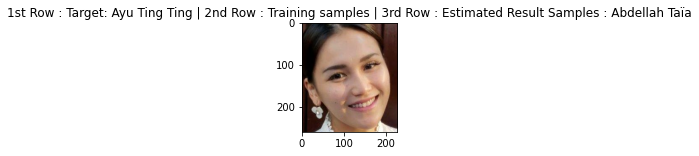

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [25]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm
%matplotlib inline

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
# org_img_path = 'Test/Daniele Suzuki.jpg'
org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.linalg.norm(embeds-centroid))

# Rank 1
    
# print(np.argmin(distance_list))
# print(np.min(distance_list))

target = id_list[np.argmin(distance_list)]

plt.figure(figsize=(4,2))
plt.title("1st Row : Target: "+org_img_path.split('/')[-1].split('.')[0] +" | 2nd Row : Training samples"+ " | 3rd Row : Estimated Result Samples : "+target)
plt.imshow(convert_img)

# dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
dir_base = "/raid/workspace/jbpark/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+org_img_path.split('/')[-1].split('.')[0]+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    
# dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
dir_base = "/raid/workspace/jbpark/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+target+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

##### Testing with Closed-set

In [26]:
distance_list = []
correct_sum=0
for index,i in tqdm(enumerate(embed_list)):
    distance_list = []
    for centroid in centroid_list:
        distance_list.append(np.linalg.norm(i-centroid))
    if id_list[label_list[index]] == id_list[np.argmin(distance_list)]:
        correct_sum+=1
#         print("True")
#     else:
#         print(id_list[label_list[index]])
#         print(id_list[np.argmin(distance_list)])
#         print("False")
print("Score: "+str(correct_sum/len(embed_list)))

13046it [06:02, 36.01it/s]

Score: 0.05794879656599724


### Rank N

In [19]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm    
import pandas as pd
%matplotlib inline

Rank = 5

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
# org_img_path = 'Test/Daniele Suzuki.jpg'
org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.linalg.norm(embeds-centroid))


df = pd.DataFrame(distance_list)
sorted_df = df.sort_values(by=0)
estimated_label = np.asarray(sorted_df[:Rank].index)

id_list = np.array(id_list)
print(id_list[estimated_label])

['Amelia Andersdotter' 'Madison Chock' 'Tata Young' 'Ayu Ting Ting'
 'Renata Przemyk']


### Testing with Cosine Similarity

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


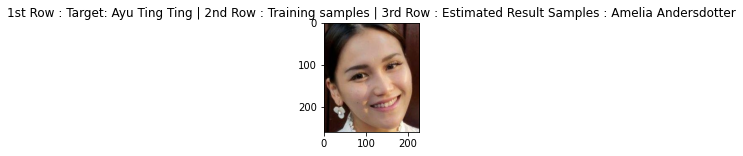

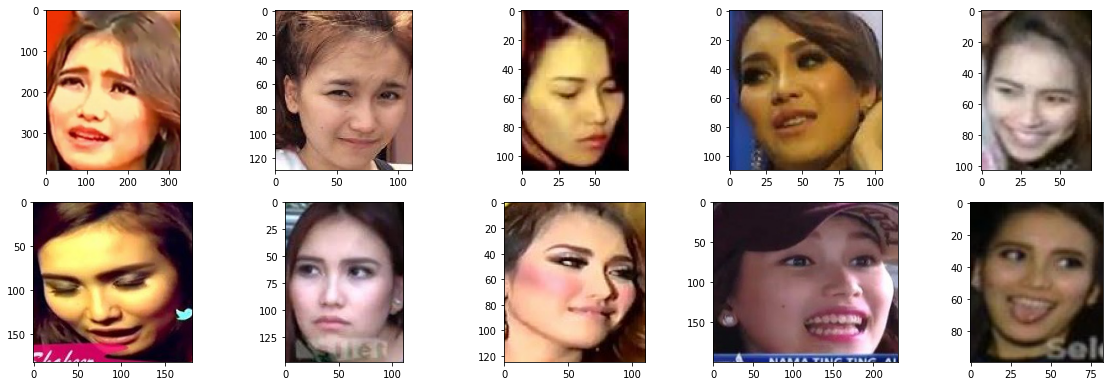

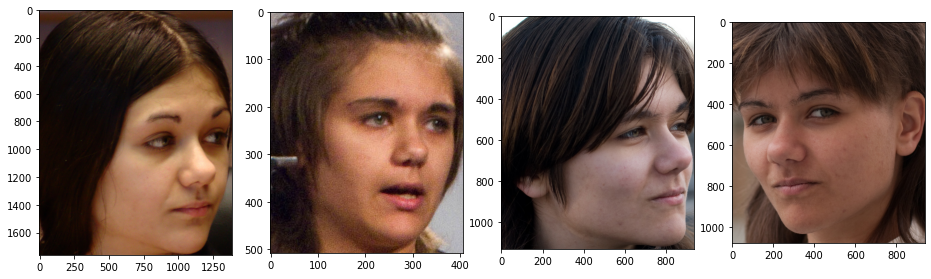

In [9]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm
%matplotlib inline

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
# org_img_path = 'Test/Daniele Suzuki.jpg'
org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.dot(embeds,centroid)/(np.linalg.norm(embeds)*np.linalg.norm(centroid)))

# Rank 1
    
# print(np.argmin(distance_list))
# print(np.min(distance_list))

target = id_list[np.argmax(distance_list)]

plt.figure(figsize=(4,2))
plt.title("1st Row : Target: "+org_img_path.split('/')[-1].split('.')[0] +" | 2nd Row : Training samples"+ " | 3rd Row : Estimated Result Samples : "+target)
plt.imshow(convert_img)

dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+org_img_path.split('/')[-1].split('.')[0]+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    
dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+target+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

##### Rank N

In [16]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm    
import pandas as pd
%matplotlib inline

Rank = 5

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
org_img_path = 'Test/Daniele Suzuki.jpg'
# org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.dot(embeds,centroid)/(np.linalg.norm(embeds)*np.linalg.norm(centroid)))


df = pd.DataFrame(distance_list)
sorted_df = df.sort_values(by=0,ascending=False)
estimated_label = np.asarray(sorted_df[:Rank].index)

id_list = np.array(id_list)
print(id_list[estimated_label])

['Nam Sang-mi' 'Kathryn Bernardo' 'Daniele Suzuki' 'Kristi Yamaguchi'
 'Ayumi Kurihara']
